# Modelo de predicción: Radiación solar
En este notebook se entrenarán diferentes algoritmos de ML para desarrollar el modelo de predicción de la radiación solar horaria con los datasets obtenidos de:


**Radiación del día anterior a la llamada** https://opendata.aemet.es/centrodedescargas/productosAEMET<br>
**Radiación solar de dos días antes del día de obtención de datos** http://www.soda-pro.com/web-services/radiation/cams-radiation-service<br>
**Datos climáticos de los cinco días anteriores a la llamada** https://openweathermap.org/api/one-call-api#history<br>
**Predicción climática de los dos días siguientes a la llamada** https://openweathermap.org/api/one-call-api<br>

- [Preparación](#Preparación)<br>

### 1. [Se importan los datos a usar para entrenar y validar el modelo](#Se-importan-los-datos-a-usar-para-entrenar-y-validar-el-modelo)

### 2. [Se dividen los datos en train y test](#Se-dividen-los-datos-en-train-y-test)

### 3. [Modelo base](#Modelo-base)

### 4. [Regresión lineal](#Regresión-lineal)

### 5. [k-Nearest Neighbors](#k-Nearest-Neighbors)

### 6. [Árbol de decisión](#Árbol-de-decisión)

### 7. [Regresión polinomial](#Regresión-polinomial)

### 8. [Gradient boosting](#Gradient-boosting)

### 9. [Random forest](#Random-forest)

### 10. [GridSearchCV](#GridSearchCV)

### 11. [Regresión lineal con GridSearchCV](#Regresión-lineal-con-GridSearchCV)

### 12. [k-Nearest Neighbors con GridSearchCV](#k-Nearest-Neighbors-con-GridSearchCV)

### 13. [Árbol de decisión con GridSearchCV](#Árbol-de-decisión-con-GridSearchCV)

### 14. [Gradient boosting con GridSearchCV](#Gradient-boosting-con-GridSearchCV)

### 15. [Random forest con Regressor RandomizedSearchCV](#Random-forest-con-Regressor-RandomizedSearchCV)

### 16. [Tensorflow](#Tensorflow)

### 17. [Selección de modelo](#Selección-de-modelo)

### 18. [Se comprueba que no haya sobreajuste](#Se-comprueba-que-no-haya-sobreajuste)

### 19. [Se guarda el modelo](#Se-guarda-el-modelo)


## Nota previa
Para poder ejecutar el script adecuadamente hay que utilizar la siguiente línea de comando para abrir el notebook desde la terminal:

In [1]:
#jupyter-lab --NotebookApp.iopub_data_rate_limit=1.0e15

**PRECAUCIÓN:** Tarda muchas horas en correr

## Preparación

Se fija el directorio de trabajo

In [2]:
%cd /home/dsc/git/TFM/

/home/dsc/git/TFM


In [3]:
directorio = '/home/dsc/git/TFM/'

Se importan las librerías necesarias

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns = None
pd.options.display.max_rows = None

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

### ``dividir_train_test()``
Esta función divide los datos en sets de train y de test:
- Train: prop (Por defecto, 80%)
- Test: 100% - prop

In [5]:
def dividir_train_test(x,y, prop = 0.8):
    
    # Proporción de train
    tam_train = prop

    # Divido en train y test
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = tam_train, random_state = 1)

    print('x_train: {}%. Nº de datos: {}'.format((len(x_train)/len(x))*100, len(x_train)))
    print('y_train: {}%. Nº de datos: {}'.format((len(y_train)/len(y))*100, len(y_train)))


    print('x_test: {}%. Nº de datos: {}'.format((len(x_test)/len(x))*100, len(x_test)))
    print('y_test: {}%. Nº de datos: {}'.format((len(y_test)/len(y))*100, len(y_test)))
    
    return x_train, x_test, y_train, y_test

### ``graf_compara()``

Esta función representa mediante barras verticales los valores reales frente a los predichos.  

In [6]:
def graf_compara(nombre_modelo, y_real, y_pred):
    
    # Valores predicción
    predic = pd.DataFrame({'Dato': y_pred})
    predic.insert(len(predic.columns),"index",[i for i in range(0,len(predic["Dato"]))],True)
    
    # Valores reales
    real = pd.DataFrame({'Dato': y_real})
    real.insert(len(real.columns),"index",[i for i in range(0,len(real["Dato"]))],True)
    
    # Comparación
    comparacion = pd.concat([real, predic], keys=["Real", "Prediccion"]).reset_index()
    comparacion.drop(['level_1'], axis=1, inplace = True)
    comparacion.columns = ['Tipo', 'Dato', "Index"]
    #print(comparacion)

    sns.catplot(data = comparacion, kind = "bar", x = "Index", y = "Dato", hue = "Tipo", estimator = np.median, height = 10, aspect = 5)

### ``mape_fun()``

In [7]:
def mape_fun(y_real, y_pred): 
    y_real, y_pred = np.array(y_real), np.array(y_pred)
    return np.mean(np.abs((y_real - y_pred) / y_real)) * 100

### ``metricas()``

Esta función calcula las diferentes métricas de la predicción arrojada por el modelo  

Métricas: ``mae``, ``mse``,``rmse``, ``r2``, ``mape``

In [8]:
def metricas(modelo, y_real, y_pred):
    
    from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
    
    # MAE: el error se calcula como un promedio de diferencias absolutas entre los valores objetivo y las predicciones. Todas las diferencias individuales se ponderan por igual en el promedio.
    mae = mean_absolute_error(y_real, y_pred)

    # MSE: mide el error cuadrado promedio de las predicciones. Para cada punto, calcula la diferencia cuadrada entre las predicciones y el objetivo y luego promedia esos valores.
    mse = mean_squared_error(y_real, y_pred, squared = False)
    
    # RMSE: es la raíz cuadrada de MSE. Tiene la escala de la variable objetivo.
    rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    
    # R^2: está estrechamente relacionada con la MSE, pero tiene la ventaja de estar libre de escala. Está siempre entre -∞ y 1.
    r2 = r2_score(y_real, y_pred)
    
    # MAPE: Para cada objeto, el error absoluto se divide por el valor objetivo, dando un error relativo.
    #mape = mape_fun(y_real, y_pred)
    
    
    print('MODEL: ', modelo)
    print('MAE: ', mae)
    print('MSE: ', mse)
    print('RMSE: ', rmse)
    print('R2 : ', r2)
    #print('MAPE : ', mape)
    
    #return modelo, mae, mse, rmse, r2, mape
    return modelo, mae, mse, rmse, r2

### ``compracion_metricas()``

Esta función representa las métricas de cada modelo entrenado, para poder compararlas.

In [9]:
def compracion_metricas(lista_modelos):
    
    plt.style.use('ggplot')
    
    # Creamos dataframes para albergar las métricas
    df_mae = pd.DataFrame(columns = ['mae', "modelo"])
    df_mse = pd.DataFrame(columns = ['mse', "modelo"])
    df_rmse = pd.DataFrame(columns = ['rmse', "modelo"])
    df_r2 = pd.DataFrame(columns = ['r2', "modelo"])
    #df_mape = pd.DataFrame(columns = ['mape', "modelo"])

    # Se llenan los dataframes con las métricas
    for modelo in lista_modelos:
        
        df_mae = df_mae.append({'mae': modelo[1], "modelo": modelo[0]}, ignore_index=True)
        df_mse = df_mse.append({'mse': modelo[2], "modelo": modelo[0]}, ignore_index=True)
        df_rmse = df_rmse.append({'rmse': modelo[3], "modelo": modelo[0]}, ignore_index=True)
        df_r2 = df_r2.append({'r2': modelo[4], "modelo": modelo[0]}, ignore_index=True)
        #df_mape = df_mape.append({'mape': modelo[5], "modelo": modelo[0]}, ignore_index=True)
    
    # Se crea la figura y añado los subplots de cada métrica
    fig = plt.figure(figsize = (15, len(lista_modelos*4)))
    ax1 = fig.add_subplot(5,1,1)
    ax2 = fig.add_subplot(5,1,2)
    ax3 = fig.add_subplot(5,1,3)
    ax4 = fig.add_subplot(5,1,4)
    #ax5 = fig.add_subplot(5,1,5)
    
    #MAE
    fig = sns.barplot(x = "mae", y = "modelo", data = df_mae, ax = ax1, orient = "h", color = 'green').set_title("Comparación de métricas")
    ax1.tick_params(labelbottom = False, bottom = False)
    ax1.set_xlabel("MAE")
    ax1.set_ylabel(" ")
    for pa in ax1.patches:
        ax1.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")
    
    #MSE
    fig = sns.barplot(x = "mse", y = "modelo", data = df_mse, ax = ax2, orient = "h", color = 'red')
    ax2.tick_params(labelbottom = False, bottom = False)
    ax2.set_xlabel("MSE")
    ax2.set_ylabel(" ")
    for pa in ax2.patches:
        ax2.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")
        
    #RMSE
    fig = sns.barplot(x = "rmse", y = "modelo", data = df_rmse, ax = ax3, orient = "h", color = 'blue')
    ax3.tick_params(labelbottom = False, bottom = False)
    ax3.set_xlabel("RMSE")
    ax3.set_ylabel(" ")
    for pa in ax3.patches:
        ax3.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")

    #R2
    fig = sns.barplot(x = "r2", y = "modelo", data = df_r2, ax = ax4, orient = "h", color = 'yellow')
    ax4.set_xlabel("R2")
    ax4.set_ylabel(" ")
    ax4.tick_params(labelbottom = False, bottom = False)
    for pa in ax4.patches:
        ax4.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
            xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")
        
    #MAPE
    #fig = sns.barplot(x = "mape", y = "modelo", data = df_mape, ax = ax5, orient = "h", color = 'grey')
    #ax5.set_xlabel("Valor de la métrica")
    #ax5.set_ylabel(" ")
    #ax5.tick_params(labelbottom = False, bottom = False)
    #for pa in ax5.patches:
    #    ax5.annotate("%.4f" % pa.get_width(), xy = (pa.get_width(), pa.get_y() + pa.get_height()/2),
    #        xytext = (5, 0), textcoords = 'offset points', ha = "left", va = "center")

# Se importan los datos a usar para entrenar y validar el modelo

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [10]:
df_datos = pd.read_csv('./data/Modelo_2/Datos_modelo_2.csv', sep=',')

df_datos.head()

,fecha_rad,hora,indicativo,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
0,2021-04-08,4,0252D,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.782415,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.782415,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,12.53,9.62,1015,53,276.37,70,9770.795014,2.06,12,2.33,803,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.04
1,2021-04-08,4,0076,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.782415,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.782415,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,14.44,11.15,1015,58,279.44,69,9770.795014,3.48,47,3.68,803,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.28
2,2021-04-08,4,0200E,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.782415,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.782415,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.19,8.87,1015,47,274.37,60,9770.795014,2.17,34,2.37,803,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.18
3,2021-04-08,4,0201D,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,14.08,11.07,1015,52,277.53,64,9770.795014,2.51,40,2.73,803,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.23
4,2021-04-08,4,0149X,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.782415,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.782415,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.95,7.33,1016,58,275.23,63,9770.795014,1.37,3,1.44,803,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,330.246106,0.0,0.0,6.46


In [11]:
#Selecciono las columnas de interés
df_datos = df_datos[["hora"] + list(df_datos.columns)[3:]]
df_datos.head()

,hora,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2,ghi,temp_objetivo
0,4,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.782415,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.782415,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,12.53,9.62,1015,53,276.37,70,9770.795014,2.06,12,2.33,803,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.04
1,4,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.782415,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.782415,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,14.44,11.15,1015,58,279.44,69,9770.795014,3.48,47,3.68,803,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.28
2,4,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.782415,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.782415,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.19,8.87,1015,47,274.37,60,9770.795014,2.17,34,2.37,803,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.18
3,4,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,14.08,11.07,1015,52,277.53,64,9770.795014,2.51,40,2.73,803,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,330.246106,0.0,0.0,8.23
4,4,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.782415,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.782415,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.95,7.33,1016,58,275.23,63,9770.795014,1.37,3,1.44,803,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,330.246106,0.0,0.0,6.46


Se determina la columna objetivo, las columnas útilies como entradas del modelo y las columnas mínimas para el modelo base

In [12]:
df_datos.shape

(156289, 77)

In [13]:
columnas_utiles = list(df_datos.columns[:-2])
columnas_objetivo = ['ghi']
columnas_minimas = ['hora'] + list(columnas_objetivo)

### Separo las variables en x e y

En función de si son columna dato u objetivo

In [14]:
df = df_datos

x = df[columnas_utiles]
y = df[columnas_objetivo]

display(x.head())
display(y.head())

,hora,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2
0,4,10.73,9.24,1010,93,282.80,0,4900.0,2.06,290,4.782415,701,10.08,8.42,1017,93,282.15,75,10000.0,2.06,280,4.782415,803,11.15,9.41,1014,93,283.21,0,10000.0,2.57,280,4.782415,800,12.02,10.81,1012,76,281.08,0,10000.0,1.03,280,4.782415,800,12.53,9.62,1015,53,276.37,70,9770.795014,2.06,12,2.33,803,41.587500,2.540000,8.800,7.250,1024.0,77.0,277.615,0.0,29.0,10000.0,2.800,240.0,4.280,0.0,801.5,0.0,0.0,330.246106,0.0
1,4,11.41,8.39,1009,87,282.48,20,7000.0,4.12,330,4.782415,801,12.20,9.96,1016,76,281.25,0,10000.0,2.57,330,4.782415,800,12.26,9.59,1013,82,282.43,0,10000.0,3.60,330,4.782415,800,12.86,9.73,1010,62,278.92,20,10000.0,3.09,310,4.782415,801,14.44,11.15,1015,58,279.44,69,9770.795014,3.48,47,3.68,803,41.292778,2.070000,11.265,10.210,1023.5,67.5,278.310,0.0,43.5,10000.0,2.290,188.0,3.465,0.0,801.5,0.0,0.0,330.246106,0.0
2,4,11.91,9.02,1010,87,282.97,20,7000.0,4.12,330,4.782415,801,12.67,10.54,1017,76,281.70,0,10000.0,2.57,330,4.782415,800,12.45,9.83,1014,82,282.62,0,10000.0,3.60,330,4.782415,800,12.99,9.88,1011,62,279.04,20,10000.0,3.09,310,4.782415,801,12.19,8.87,1015,47,274.37,60,9770.795014,2.17,34,2.37,803,41.418333,2.124167,8.040,5.445,1024.5,70.5,277.075,0.0,37.5,10000.0,1.560,191.0,2.525,0.0,801.5,0.0,0.0,330.246106,0.0
3,4,11.87,8.97,1010,87,282.93,20,7000.0,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.0,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.0,3.60,330,4.782415,800,13.01,9.91,1011,62,279.06,20,10000.0,3.09,310,4.782415,801,14.08,11.07,1015,52,277.53,64,9770.795014,2.51,40,2.73,803,41.390556,2.200000,10.525,9.365,1024.5,69.0,277.935,0.0,38.5,10000.0,1.930,200.5,3.005,0.0,801.5,0.0,0.0,330.246106,0.0
4,4,8.55,6.52,1009,93,280.63,1,4900.0,2.06,290,4.782415,701,8.81,6.84,1017,93,280.89,75,10000.0,2.06,280,4.782415,803,9.43,7.25,1013,93,281.51,0,10000.0,2.57,280,4.782415,800,10.90,9.44,1011,76,279.99,0,10000.0,1.03,280,4.782415,800,9.95,7.33,1016,58,275.23,63,9770.795014,1.37,3,1.44,803,41.720000,1.840278,4.715,4.715,1024.5,89.5,275.635,0.0,35.0,10000.0,0.945,197.0,1.045,0.0,802.0,0.0,0.0,330.246106,0.0


,ghi
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


# Se dividen los datos en train y test

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [15]:
x_train, x_test, y_train, y_test = dividir_train_test(x,y, 0.7)

x_train: 69.99980804791124%. Nº de datos: 109402
y_train: 69.99980804791124%. Nº de datos: 109402
x_test: 30.000191952088755%. Nº de datos: 46887
y_test: 30.000191952088755%. Nº de datos: 46887


# Estandarización
<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [16]:
x_train.head()

,hora,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2
133705,5,3.09,-0.92,1020,100,276.24,0,10000.0,3.60,20,4.782415,800,6.90,5.23,1016,93,279.00,99,9000.0,1.03,60,4.782415,804,8.21,6.47,1018,93,280.30,0,10000.0,1.54,60,4.782415,800,4.27,2.45,1026,93,276.39,94,8000.0,0.51,0,4.782415,804,4.64,2.40,1027,91,276.45,96,9770.795014,1.13,100,1.600000,804,42.421111,-3.170278,4.620,4.620,1026.0,91.5,275.895,0.000,41.0,10000.0,0.955,118.0,1.165,0.00,802.0,33.333333,0.062084,330.246106,64.3339
150778,12,19.55,20.42,1015,94,291.71,75,6000.0,3.09,70,4.782415,803,21.37,18.41,1017,77,290.32,75,10000.0,7.72,100,4.782415,803,23.39,21.49,1019,64,289.35,0,10000.0,5.66,70,4.782415,800,21.56,16.56,1022,35,278.61,0,10000.0,5.66,200,4.782415,800,17.87,10.67,1017,59,282.91,91,9770.795014,10.25,259,11.260000,804,35.895556,-5.292222,18.785,18.820,1018.0,80.5,288.980,8.340,93.5,10000.0,5.130,76.5,6.725,0.00,804.0,338.888889,0.081944,330.246106,762.3703
14794,14,21.66,20.71,1021,40,280.64,0,10000.0,0.51,60,4.782415,800,18.91,16.71,1016,60,284.13,0,10000.0,3.60,270,4.782415,800,17.08,14.02,1012,82,287.14,40,10000.0,6.17,200,4.782415,500,20.57,17.48,1015,43,280.72,20,10000.0,3.60,220,4.782415,801,20.32,17.88,1018,52,283.30,75,10000.000000,3.60,70,4.782415,803,38.298611,-6.765000,21.660,20.995,1015.0,42.5,281.525,5.275,79.0,10000.0,2.885,244.5,2.550,0.01,803.5,741.666667,0.084167,269.444444,651.5646
12285,9,11.44,10.47,1013,76,280.51,75,8000.0,0.51,0,4.782415,803,11.41,10.43,1014,76,280.49,75,10000.0,0.51,0,4.782415,803,7.45,3.61,1019,100,280.60,90,200.0,4.63,100,4.782415,500,9.57,8.27,1020,87,280.67,90,10000.0,1.03,0,4.782415,804,9.52,6.60,1018,46,271.81,0,10000.000000,1.03,0,4.782415,800,41.006944,-3.613611,9.210,8.285,1023.5,50.5,271.910,2.305,86.0,10000.0,1.185,123.5,1.405,0.00,803.5,777.777778,0.100833,313.888889,379.1842
110590,14,23.82,23.90,1019,68,290.71,0,10000.0,3.60,80,4.782415,800,29.09,25.73,1016,32,283.88,20,10000.0,5.14,280,4.782415,801,30.45,26.78,1014,30,284.09,0,10000.0,5.66,270,4.782415,800,25.36,22.84,1015,41,284.32,0,10000.0,4.12,20,4.782415,800,25.45,21.73,1016,43,285.12,20,10000.000000,6.17,260,4.782415,801,35.276389,-2.956389,22.065,22.115,1019.0,68.5,289.005,7.795,71.5,10000.0,5.035,58.0,5.155,0.00,803.0,358.333333,0.072500,330.246106,763.3627


In [17]:
x_test.head()

,hora,temp_d-1,feels_like_d-1,pressure_d-1,humidity_d-1,dew_point_d-1,clouds_d-1,visibility_d-1,wind_speed_d-1,wind_deg_d-1,wind_gust_d-1,we_d-1,temp_d-2,feels_like_d-2,pressure_d-2,humidity_d-2,dew_point_d-2,clouds_d-2,visibility_d-2,wind_speed_d-2,wind_deg_d-2,wind_gust_d-2,we_d-2,temp_d-3,feels_like_d-3,pressure_d-3,humidity_d-3,dew_point_d-3,clouds_d-3,visibility_d-3,wind_speed_d-3,wind_deg_d-3,wind_gust_d-3,we_d-3,temp_d-4,feels_like_d-4,pressure_d-4,humidity_d-4,dew_point_d-4,clouds_d-4,visibility_d-4,wind_speed_d-4,wind_deg_d-4,wind_gust_d-4,we_d-4,temp_d-5,feels_like_d-5,pressure_d-5,humidity_d-5,dew_point_d-5,clouds_d-5,visibility_d-5,wind_speed_d-5,wind_deg_d-5,wind_gust_d-5,we_d-5,lat,lon,temp_pred,feels_like_pred,pressure_pred,humidity_pred,dew_point_pred,uvi_pred,clouds_pred,visibility_pred,wind_speed_pred,wind_deg_pred,wind_gust_pred,pop_pred,we_pred,rad_d-1,uvb_d-1,ir_d-1,rad_d-2
82530,4,5.56,3.34,1015,91,277.36,99,9770.795014,1.34,180,2.240000,804,5.00,3.24,1017,98,277.86,9,9770.795014,0.82,249,0.870000,800,2.22,-1.35,1021,93,274.36,99,9770.795014,2.53,67,3.670000,804,5.00,2.88,1017,87,276.17,100,9770.795014,0.89,320,0.890000,804,3.71,0.42,1012,93,275.83,68,9770.795014,2.47,15,2.610000,803,41.086389,-2.618056,10.625,9.970,1017.0,64.0,276.940,0.000,4.0,10000.0,1.520,240.0,1.730,0.00,800.0,0.000000,0.062084,255.555556,0.0000
108236,14,18.33,13.24,1021,61,283.84,99,9770.795014,7.60,294,9.830000,804,18.89,15.79,1021,43,279.20,57,9770.795014,3.13,231,6.710000,803,17.78,12.35,1016,58,282.57,100,9770.795014,7.60,252,10.730000,804,16.67,14.85,1012,100,289.82,100,9770.795014,5.81,230,8.940000,500,16.11,13.14,1018,69,283.58,100,9770.795014,4.47,183,8.050000,804,43.524722,-7.031389,19.085,18.355,1024.0,50.0,280.990,7.345,24.5,10000.0,2.825,185.0,2.810,0.00,801.0,552.777778,0.062084,330.246106,809.2432
54691,14,13.01,10.60,1009,76,282.03,75,10000.000000,3.09,310,4.782415,803,14.19,11.17,1001,59,279.45,40,10000.000000,3.09,320,4.782415,802,15.95,16.49,1007,82,286.03,75,10000.000000,0.51,0,4.782415,803,22.12,19.08,1008,52,284.96,0,10000.000000,5.14,130,4.782415,800,22.08,17.72,1007,33,278.23,20,10000.000000,4.63,140,4.782415,801,43.376944,-2.510278,11.835,10.980,1011.5,73.0,280.065,4.270,96.5,10000.0,1.205,266.5,1.665,0.19,652.0,152.777778,0.028611,330.246106,253.0385
99765,11,15.00,13.75,1017,88,286.18,100,9770.795014,3.13,242,6.710000,804,16.67,14.85,1018,75,285.37,89,9770.795014,3.58,258,8.050000,804,15.00,13.66,1020,64,281.40,41,9770.795014,1.34,256,4.470000,802,12.78,9.81,1017,79,282.38,78,9770.795014,4.02,211,7.600000,803,10.88,6.93,1019,79,280.54,70,9770.795014,4.77,269,8.780000,803,40.635000,-6.600000,17.050,16.300,1021.0,57.0,281.555,6.990,55.0,10000.0,3.390,314.0,4.720,0.00,802.5,705.555556,0.172500,377.777778,706.2278
2163,4,8.59,4.68,1015,71,276.79,75,10000.000000,3.60,90,4.782415,803,11.87,8.97,1010,87,282.93,20,7000.000000,4.12,330,4.782415,801,12.69,10.56,1017,76,281.72,0,10000.000000,2.57,330,4.782415,800,12.49,9.88,1014,82,282.65,0,10000.000000,3.60,330,4.782415,800,14.87,13.75,1011,63,281.05,93,9770.795014,0.90,306,0.990000,804,41.390556,2.200000,11.455,10.590,1019.5,74.0,279.845,0.000,73.5,10000.0,1.905,243.0,2.380,0.00,803.5,0.000000,0.000000,330.246106,0.0000


Se aplica la estandarización ``StandardScaler`` a los datos, eliminando la media y escalando los datos de forma que su varianza sea igual a 1

Conjunto de train

In [18]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
columnas = x_train.columns
x_train_normal = scaler.fit_transform(x_train[columnas])
x_train_normal = pd.DataFrame(x_train_normal, columns = columnas)

print(x_train_normal.head())

       hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  \
0 -1.413444 -2.399340        0.004276      0.595828      0.004276   
1  0.104623  0.669042        0.004276      0.090866      0.004276   
2  0.538357  1.062376        0.004276      0.696821      0.004276   
3 -0.545977 -0.842780        0.004276     -0.111119      0.004276   
4  0.538357  1.465031        0.004276      0.494836      0.004276   

   dew_point_d-1  clouds_d-1  visibility_d-1  wind_speed_d-1  wind_deg_d-1  \
0      -1.103080   -1.083627        0.239463        0.037269     -1.281169   
1       2.196994    1.018117       -3.973074       -0.170514     -0.839902   
2      -0.164468   -1.083627        0.239463       -1.221648     -0.928156   
3      -0.192200    1.018117       -1.866806       -1.221648     -1.457675   
4       1.983674   -1.083627        0.239463        0.037269     -0.751649   

   wind_gust_d-1    we_d-1  temp_d-2  feels_like_d-2  pressure_d-2  \
0      -0.027605  0.277569 -1.663129        0.

Se archiva el Scaler

In [19]:
import pickle as pk

with open(directorio + 'data/Modelo_2/scaler_rad.pkl', 'wb') as file:
            pk.dump(scaler, file)

Conjunto de test

In [20]:
columnas = x_test.columns
x_test_normal = scaler.transform(x_test[columnas])
x_test_normal = pd.DataFrame(x_test_normal, columns = columnas)

print(x_test_normal.head())

       hora  temp_d-1  feels_like_d-1  pressure_d-1  humidity_d-1  \
0 -1.630311 -1.938896        0.004276      0.090866      0.004276   
1  0.538357  0.441616        0.004276      0.696821      0.004276   
2  0.538357 -0.550109        0.004276     -0.515089      0.004276   
3 -0.112243 -0.179144        0.004276      0.292851      0.004276   
4 -1.630311 -1.374061        0.004276      0.090866      0.004276   

   dew_point_d-1  clouds_d-1  visibility_d-1  wind_speed_d-1  wind_deg_d-1  \
0      -0.864160    1.690675       -0.001921       -0.883492      0.130883   
1       0.518159    1.690675       -0.001921        1.666934      1.136971   
2       0.132048    1.018117        0.239463       -0.170514      1.278176   
3       1.017330    1.718698       -0.001921       -0.154217      0.678054   
4      -0.985753    1.018117        0.239463        0.037269     -0.663396   

   wind_gust_d-1    we_d-1  temp_d-2  feels_like_d-2  pressure_d-2  \
0      -1.349481  0.324044 -2.019329        0.

In [21]:
x_train_normal.shape

(109402, 75)

In [22]:
x_test_normal.shape

(46887, 75)

# PCA
<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Se aplica PCA al dataset. El análisis de componentes principales (PCA) es una técnica utilizada para describir un conjunto de datos en términos de nuevas variables («componentes») no correlacionadas. El PCA busca la proyección según la cual los datos queden mejor representados en términos de mínimos cuadrados. Esta convierte un conjunto de observaciones de variables posiblemente correlacionadas en un conjunto de valores de variables sin correlación lineal llamadas componentes principales. 

Conjunto de train

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components = "mle")
principalComponents = pca.fit_transform(x_train_normal)
x_train_pca = pd.DataFrame(data = principalComponents)

En este caso, el número de componentes será:

In [24]:
pca.n_components_

74

Se representa la varianza explicada acumulada en función del número de componentes, para tratar de buscar el número para el que la curva satura.

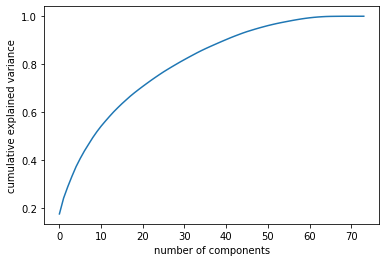

In [25]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Se observa que la curva satura con 62 componentes, que serán las que se utilizen

In [26]:
pca = PCA(n_components = 62)
principalComponents = pca.fit_transform(x_train_normal)
x_train_pca = pd.DataFrame(data = principalComponents)

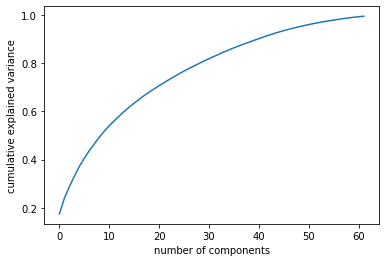

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Se archiva el PCA

In [28]:
import pickle as pk

with open(directorio + 'data/Modelo_2/pca_rad.pkl', 'wb') as file:
            pk.dump(pca, file)

Conjunto de test

In [29]:
principalComponents = pca.transform(x_test_normal)
x_test_pca = pd.DataFrame(data = principalComponents)

In [30]:
x_train_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,-7.686931,0.083661,-1.413161,-2.692586,-0.350322,0.645370,0.931510,-0.212690,-0.244309,0.862131,-0.321032,-1.396479,-0.900279,0.082716,1.280259,0.605958,-0.841389,0.191758,-0.391690,0.146726,0.760941,-0.514712,-0.972608,0.554096,0.330146,0.287538,-0.224597,-0.404950,-0.356868,0.934714,0.513495,-0.471501,0.320913,-0.543606,-0.292005,-1.171956,-0.824638,0.057883,-0.440174,-0.226890,0.181319,-0.266391,0.533855,0.981221,-1.702128,0.331706,0.926747,1.129636,0.917945,0.163517,0.293520,-0.411994,0.555596,-0.038599,-0.503360,-0.421556,-0.341864,0.285383,0.290285,-0.413915,-0.051963,0.267991
1,4.370595,-2.168908,-0.866780,-1.148755,-1.572579,-2.359698,-0.125105,-1.383293,-0.473866,3.054876,2.971480,0.617947,-0.360315,0.074039,-0.591467,-0.388875,0.825707,0.345513,-1.250445,0.615488,-1.078577,0.334047,-0.563410,-0.125425,-1.636525,-0.464187,-0.259419,0.249832,-0.064270,-0.074121,1.876519,0.117890,0.111871,0.994506,1.106192,0.201073,0.073797,-1.553250,-1.478018,0.698383,2.156265,0.279983,0.110304,-0.422113,0.699652,0.031393,0.889101,0.515920,0.217508,0.308268,0.743419,0.698446,-0.625830,-0.464593,0.570254,-0.115129,-0.326582,1.119174,-0.664452,-0.645537,0.667475,0.565893
2,2.784670,0.651110,-1.423171,-0.615984,1.125159,0.274421,0.674422,0.405930,-0.023902,-0.536493,-1.340833,0.711963,1.201590,1.987225,-0.558918,-0.209300,1.191339,-1.435010,-0.440607,0.054464,-0.441799,-0.072634,1.200206,-0.059473,-0.500591,0.048160,-0.985858,1.389206,-0.785099,-1.025144,-0.820194,-0.432187,-0.797305,0.461611,0.622598,-0.285192,0.305697,-0.271955,-0.804624,-0.980439,1.051139,-0.839911,0.999579,0.405350,0.421806,-0.821555,0.279674,0.475001,-1.185107,0.567901,0.483573,0.665959,0.151784,-0.255091,0.356596,-0.336779,0.032480,0.208999,-0.085493,0.265890,0.235147,0.175001
3,-5.092183,0.192460,-1.099725,-1.302156,3.187934,-1.697533,0.478821,-0.741655,-0.262244,3.695879,-3.074275,-2.644377,2.566515,3.800026,-1.735263,-1.262417,4.114105,-2.129863,-0.482582,-0.086284,0.210122,-1.064945,0.104759,-0.047201,-0.077305,0.173517,1.069953,-1.076385,-0.466494,2.391055,0.609904,0.497084,-0.296703,-0.454587,0.220939,3.333155,-2.242920,0.821191,0.029177,2.286945,-1.692333,2.471181,0.187213,-0.493016,-0.380247,-0.408085,-0.187951,-0.251545,-0.872126,1.170901,0.371633,0.127557,0.614436,0.378636,-0.594106,-0.174047,0.278610,-0.153272,-0.191656,0.287113,-0.145259,-0.376933
4,7.257023,-0.057174,-2.008899,0.536324,-1.614408,0.009873,0.700422,-0.195162,0.083971,0.571507,0.237846,0.357078,-0.141196,0.042489,0.528407,-0.225944,0.358344,0.473464,-0.612250,-0.050552,-1.029779,-1.299068,-0.748278,-0.828123,-0.799014,0.218693,-0.540616,0.224633,0.840966,0.708627,-0.330862,-1.382215,0.611284,0.287889,0.151010,0.074369,-0.427752,0.059463,-0.540383,0.144802,-0.089890,-0.468519,0.147450,0.009469,0.045514,1.160845,0.011667,-0.334867,-0.186296,-0.585919,0.216084,0.391342,-0.032650,-0.357756,0.500158,-0.174219,-0.540456,1.520900,0.081432,-0.543372,0.645776,0.820914


In [31]:
x_train_pca.shape

(109402, 62)

In [32]:
x_test_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61
0,-7.800042,1.015228,-0.276964,-1.821951,0.791748,2.191039,-0.396844,-0.523099,-0.052488,0.219644,-0.125812,1.287166,0.801420,-1.731444,-1.243983,0.427351,-0.199151,-1.475567,-0.058843,0.078114,-0.322947,0.350909,1.467015,-0.065662,1.392022,-0.339050,0.836179,0.236257,-0.479742,-0.162472,1.072819,0.426326,-1.670863,-1.551687,0.527377,-0.694942,-0.186895,0.041525,-0.358833,-0.409166,-0.479808,0.180664,0.315243,-0.137644,2.017074,0.452986,-1.001049,0.221403,-0.589540,0.720273,-0.156878,-0.140710,0.014363,-0.398324,-0.129801,0.174174,0.204077,-1.101575,0.127568,-0.044730,-0.120873,0.695582
1,2.177128,-1.690981,0.798859,-3.076424,3.170232,-1.916305,-2.289808,0.431948,0.642794,-1.405913,0.479749,-2.449225,1.183806,-0.492246,0.937926,0.101429,-2.321333,-0.876768,-0.724714,-0.606527,1.162290,-0.738397,-0.579202,1.295602,0.152838,-0.984854,-0.233113,0.108122,0.829388,0.378652,-0.523781,0.275734,-0.729745,-1.498260,-0.475308,0.128655,-0.195789,-0.279567,-1.087030,0.610021,-0.381739,-0.561310,-1.574547,-0.383850,1.061701,-0.120100,-0.010652,-1.224899,0.087686,-0.433979,-0.018718,-0.353530,0.270623,0.114095,0.978333,0.317242,-0.242662,0.390117,0.252260,0.108656,0.063705,0.364180
2,0.336352,0.002196,0.556303,3.357590,0.028993,-0.091093,0.541330,0.202224,0.001672,0.197573,-1.350267,-0.099236,0.726667,1.096864,0.278522,-0.580924,-1.287792,0.616111,-1.706626,-0.615438,0.960066,1.074052,1.063213,-0.169669,-0.806194,0.345898,1.535047,-0.920932,0.716477,-0.825899,0.316910,-0.093492,-0.492086,-0.000233,0.788112,-0.370800,1.161168,-0.314394,0.140015,-0.039963,-0.117410,0.175855,0.342319,-0.758933,1.071288,-0.176751,0.771592,-0.231716,0.548489,-1.055994,0.344342,0.191963,0.114043,-0.866961,0.140234,0.892854,0.263000,-0.001307,-0.183804,-0.386515,1.236834,0.319709
3,0.588317,-0.154440,-0.075897,-2.040118,2.109391,-1.858174,-1.501258,-0.936592,-0.131163,0.565248,2.190946,0.622679,0.726217,-0.341723,-0.312279,-0.301342,-1.683260,1.349069,-0.335180,0.854450,1.132813,0.782569,-0.077135,0.924870,-0.595834,1.067674,0.430498,-0.820318,-0.189429,1.241732,-0.918930,0.321716,0.042102,-0.491168,0.014684,0.585326,-1.045457,0.258085,-0.460670,-0.654938,0.214281,0.188791,-0.495703,0.601768,-0.459455,-0.414505,0.425036,-0.154829,0.075126,0.057522,0.066612,-0.244549,0.058155,0.043206,-0.481429,-0.121774,0.257003,-0.214942,-0.502529,-0.528089,0.003140,0.013719
4,-2.912428,-0.330112,-0.646408,0.546661,-0.620479,1.756445,-1.471257,0.197747,-0.033002,-0.563175,0.461260,0.324795,0.687105,1.204441,2.492027,-0.450071,-1.155662,0.932637,1.806073,0.633793,-0.947145,0.310124,-0.407754,-0.050077,-0.575675,0.322015,0.685428,-0.240521,-0.764782,1.036398,0.407401,-1.166890,-1.004176,0.040247,-0.678455,0.193222,0.758947,-0.368898,-0.361444,0.420471,-0.309457,-2.044367,1.283119,-0.122278,0.953791,-0.419730,-0.352429,0.260972,0.895877,-0.163054,-0.164014,0.133356,0.173477,-0.080051,-0.031962,-0.606405,0.443835,-0.507309,-0.265359,-0.209147,0.093309,0.105157


In [33]:
x_test_pca.shape

(46887, 62)

### Sanity check

Se comprueba si alguna de las componentes no sigue una distribución normal

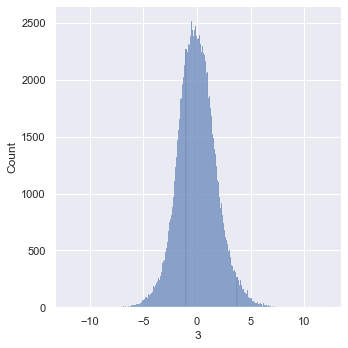

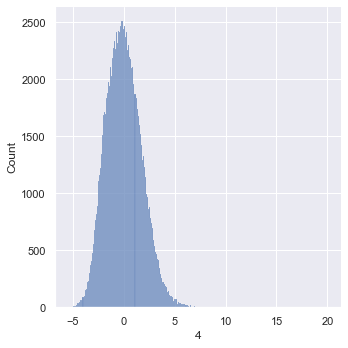

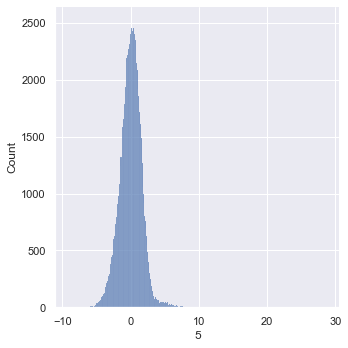

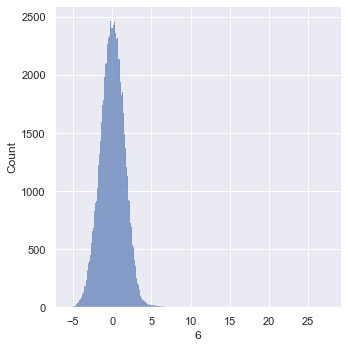

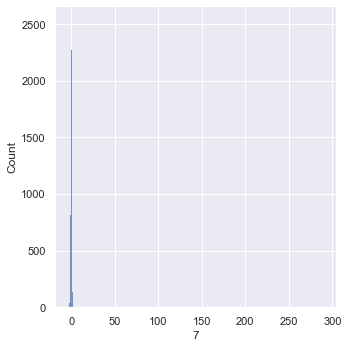

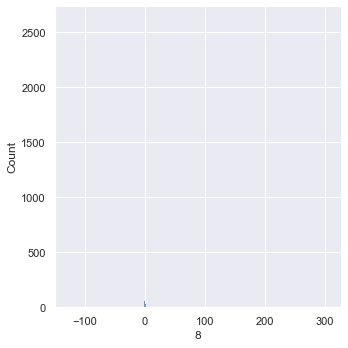

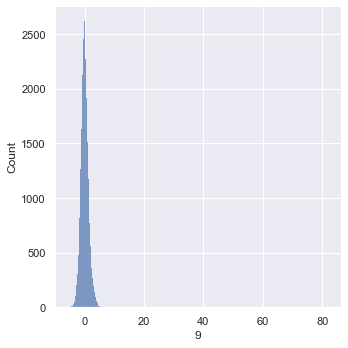

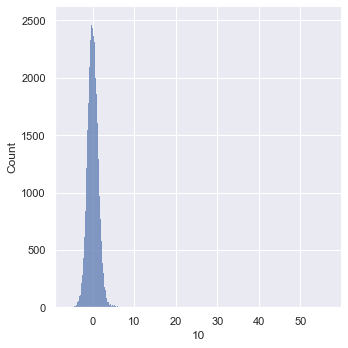

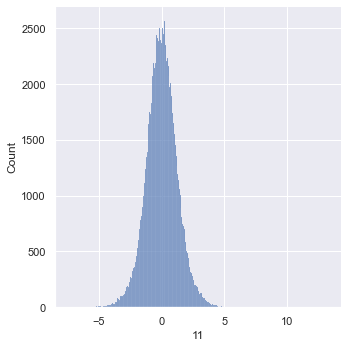

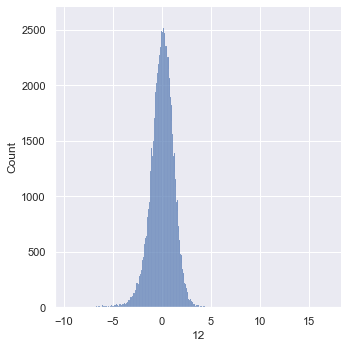

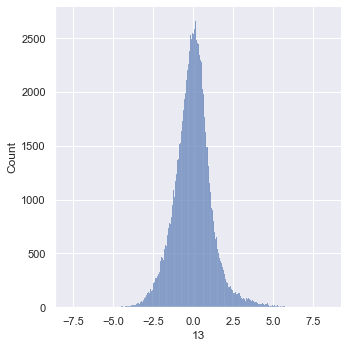

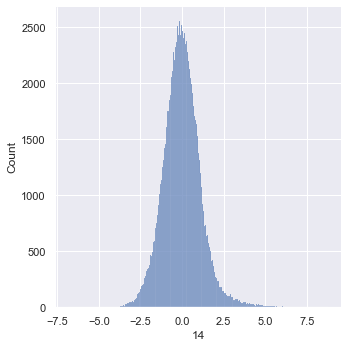

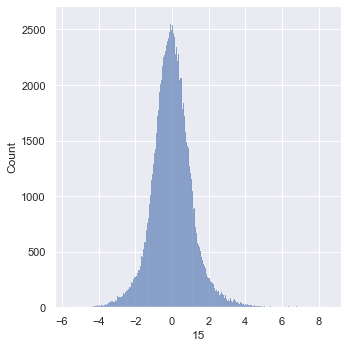

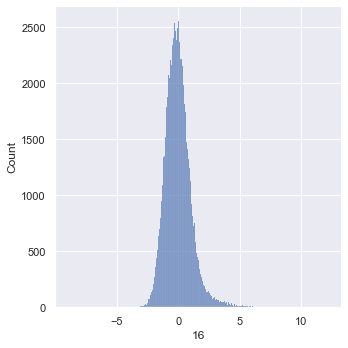

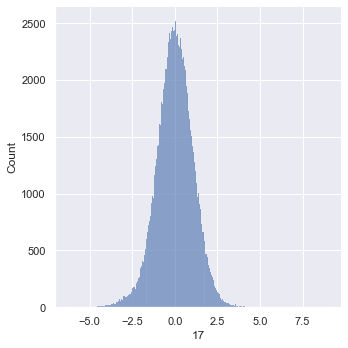

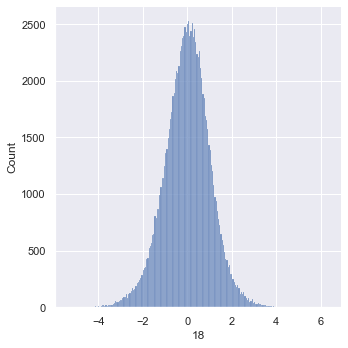

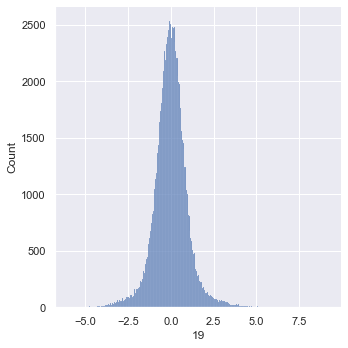

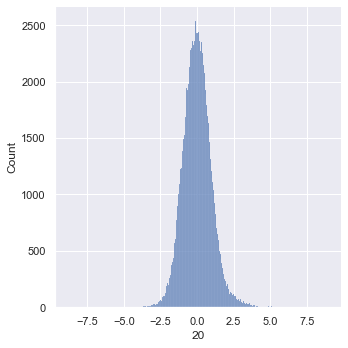

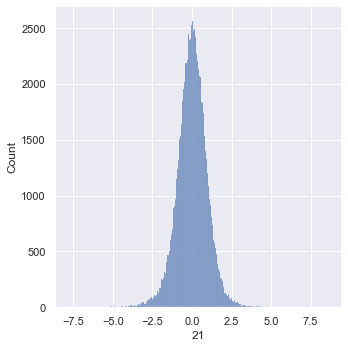

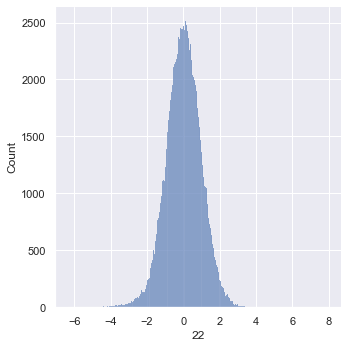

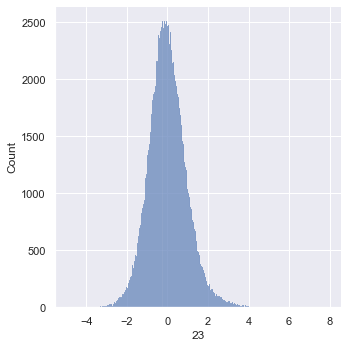

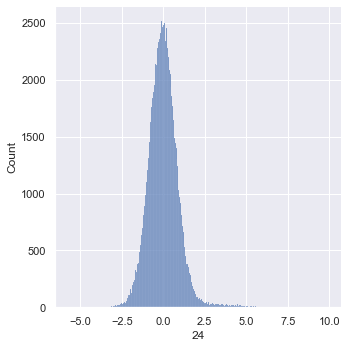

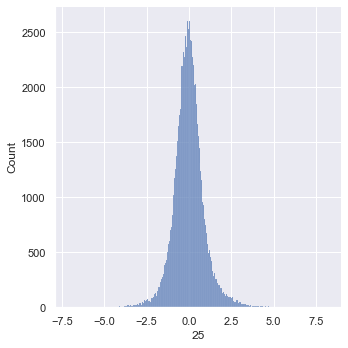

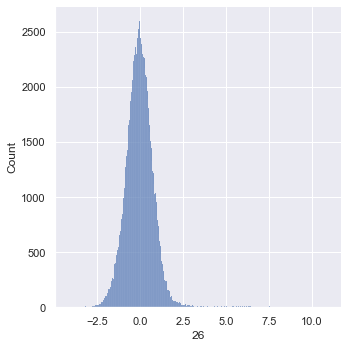

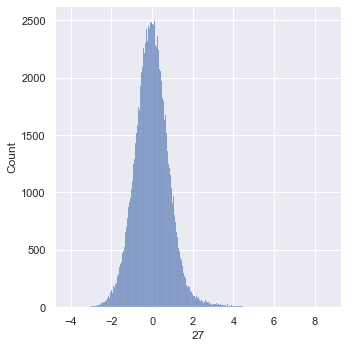

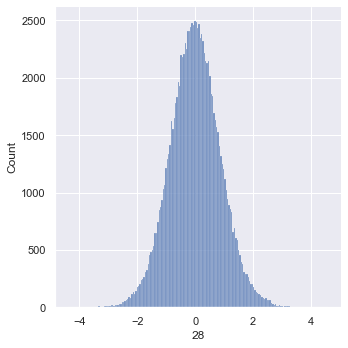

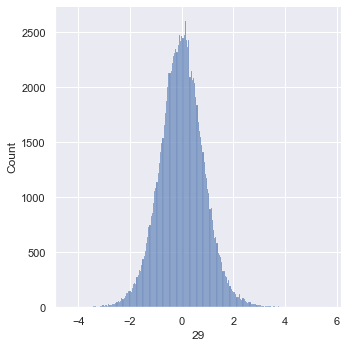

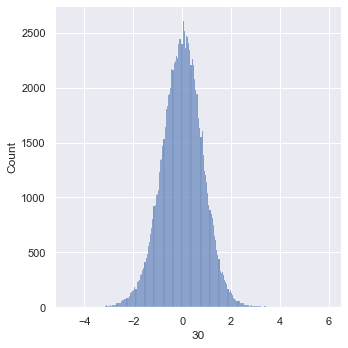

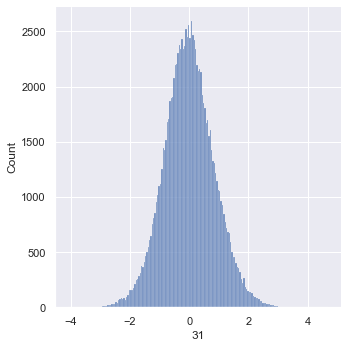

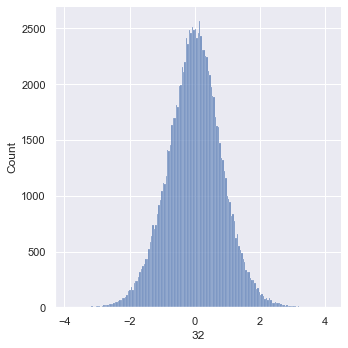

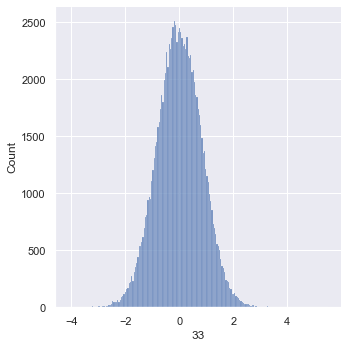

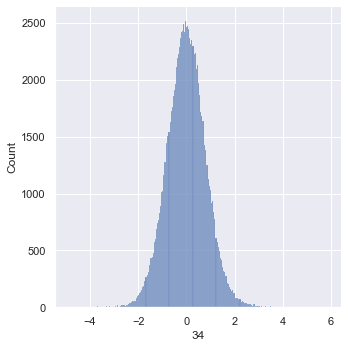

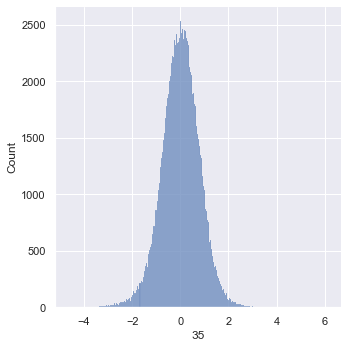

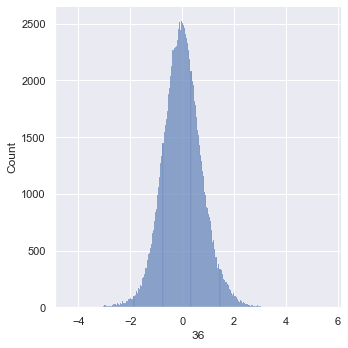

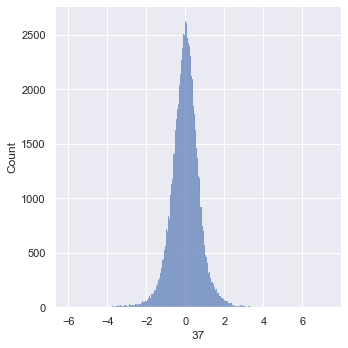

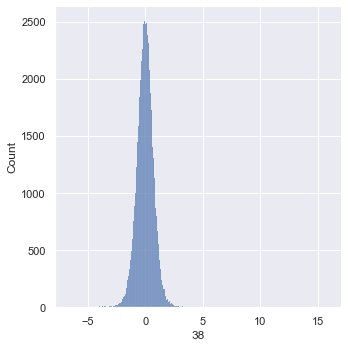

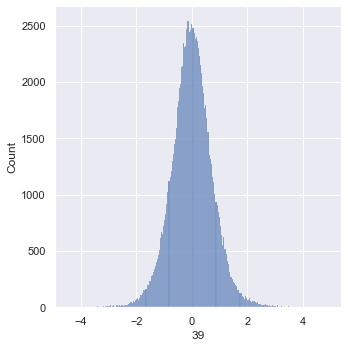

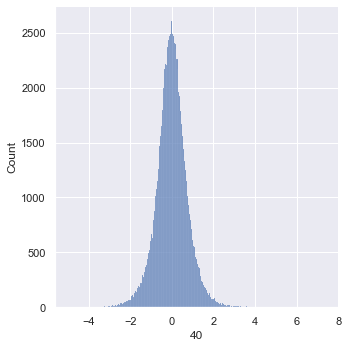

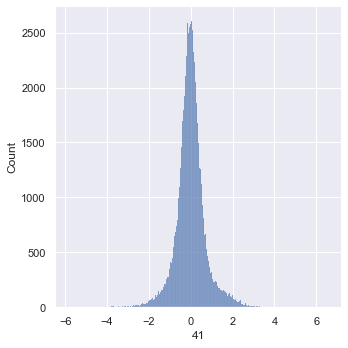

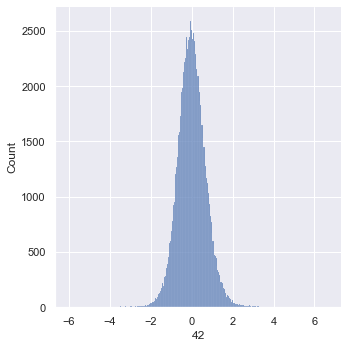

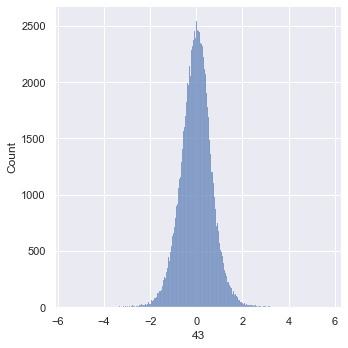

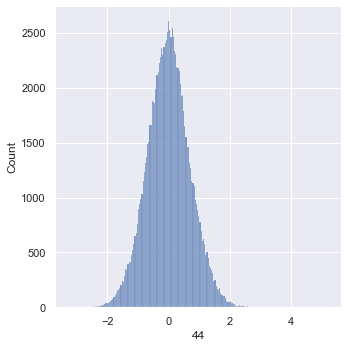

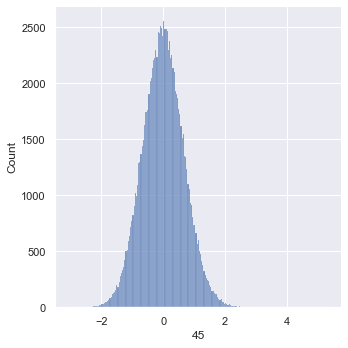

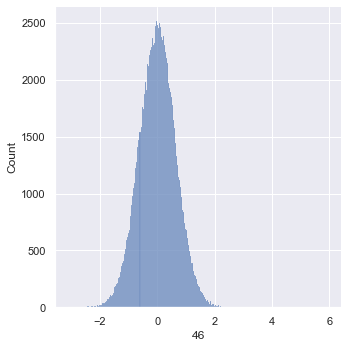

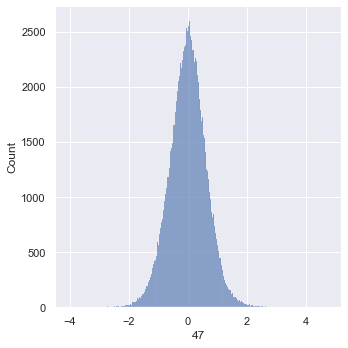

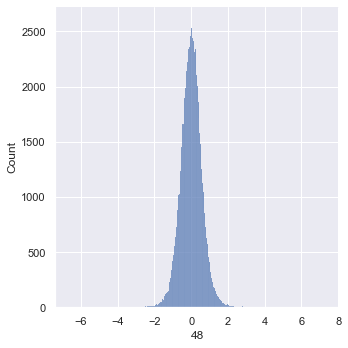

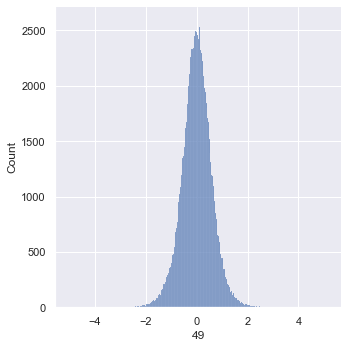

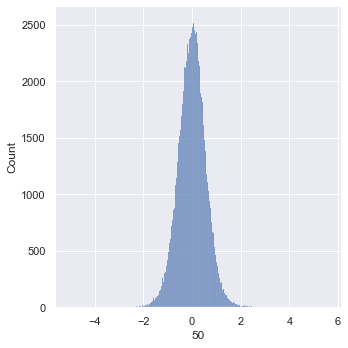

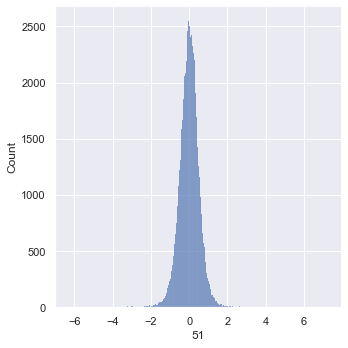

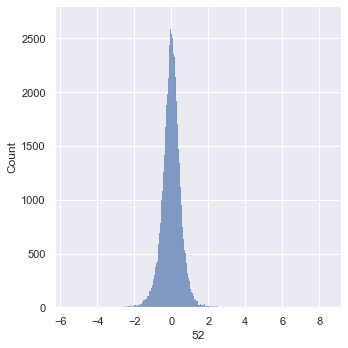

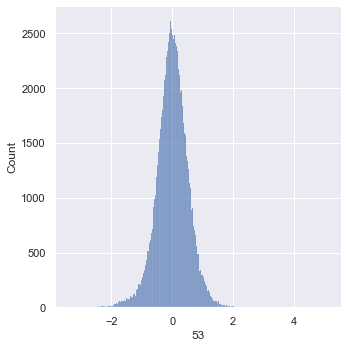

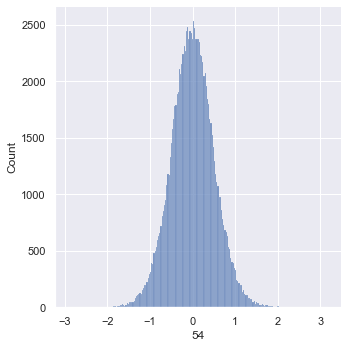

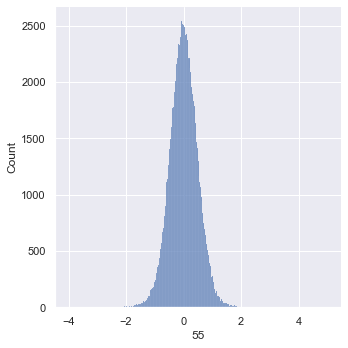

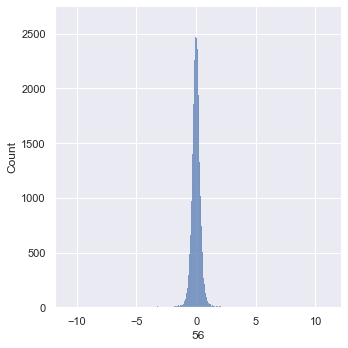

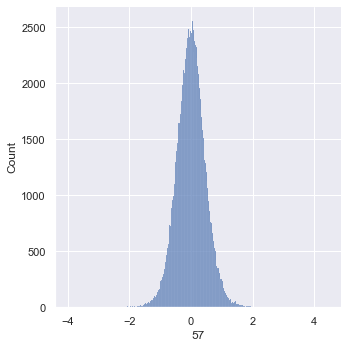

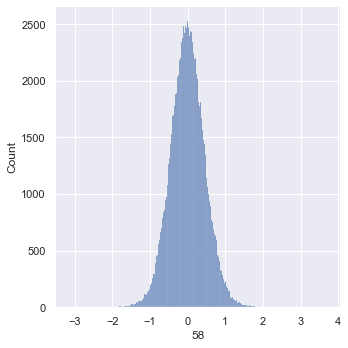

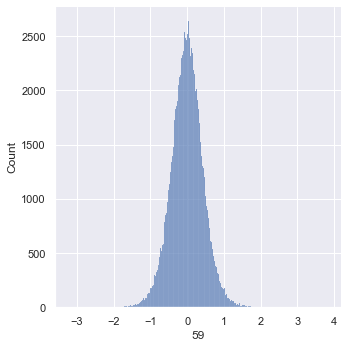

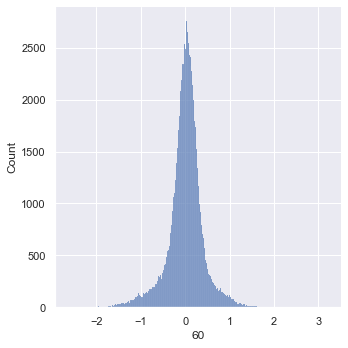

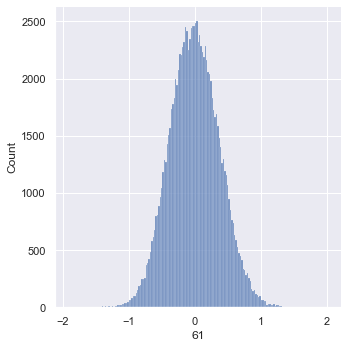

In [34]:
for i in range(3, len(x_train_pca.columns)):
    sns.set()
    cols = list(x_train_pca.columns)[i]
    sns.displot(x_train_pca[cols])
    plt.show();

Se comprueba que ninguna de las variables requiere del uso de transformaciones Yeo-Johnson o Box-Cox.

Se comprueba que las diferentes componentes no tiene relación entre si

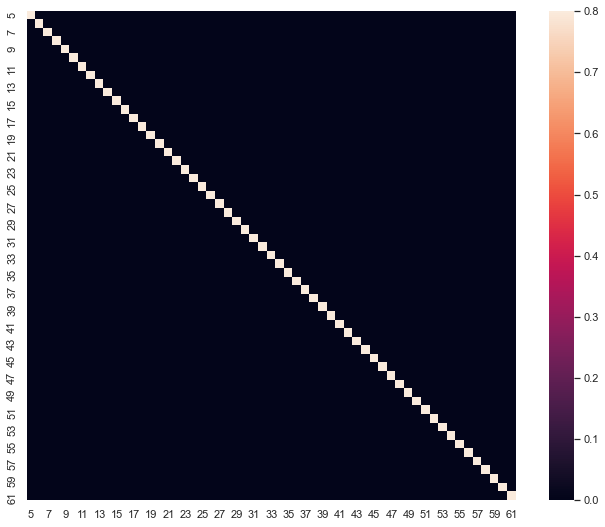

In [35]:
corrmat = x_train_pca[x_train_pca.columns[5:]].corr()
f, ax = plt.subplots(figsize = (12, 9))
sns.heatmap(corrmat, vmax = 0.8, square = True);

# Modelo base

<div style = "float:right"><a style="text-decoration:none" href = "#SModelo-de-predicción:-Radiación-solar">

Se genera un primer modelo como base para las comparaciones. Este sencillamente obtiene el valor medio por hora de la variable objetivo, asignando el valor predicción en función de la hora de los datos de entrada.

In [36]:
# Datos a usar
datos_media = df[columnas_minimas]

# Se obtienen las medias por hora
datos_media = datos_media.groupby(columnas_minimas[:-1]).mean()
datos_media

,ghi
hora,
4,0.366551
5,24.780662
6,128.178259
7,277.122189
8,433.193564
9,570.833793
10,686.200346
11,772.285421
12,788.114143


In [37]:
def modelo_medias_hora(datos, x_test):
    datos = pd.DataFrame(datos).reset_index()
    
    # Se seleccionan las columnas de interés
    x_test = x_test[columnas_minimas[:-1]]
    
    # Se asigna el valor medio por hora
    predicciones = []
    [predicciones.append([datos[datos[columnas_minimas[:-1][0]] == fila[columnas_minimas[:-1][0]]][[columnas_objetivo[0]]][columnas_objetivo[0]].iloc[0]][0]) for index,fila in x_test.iterrows()]

    return predicciones

In [38]:
pred_media = modelo_medias_hora(datos_media, x_test)
pred_media[:1000]

[0.3665512057465361,
 628.766848461302,
 628.766848461302,
 772.2854208214154,
 0.3665512057465361,
 788.114142534031,
 788.114142534031,
 5.314793810207003,
 277.1221887648497,
 719.1924958593206,
 74.96830506912457,
 628.766848461302,
 277.1221887648497,
 719.1924958593206,
 0.3665512057465361,
 212.01159093794817,
 0.3665512057465361,
 74.96830506912457,
 277.1221887648497,
 128.17825863552582,
 0.3665512057465361,
 277.1221887648497,
 5.314793810207003,
 277.1221887648497,
 505.96618237520204,
 212.01159093794817,
 74.96830506912457,
 5.314793810207003,
 719.1924958593206,
 772.2854208214154,
 74.96830506912457,
 788.114142534031,
 772.2854208214154,
 433.1935643793542,
 277.1221887648497,
 772.2854208214154,
 212.01159093794817,
 24.780662147182635,
 24.780662147182635,
 0.3665512057465361,
 212.01159093794817,
 24.780662147182635,
 719.1924958593206,
 570.8337933681264,
 570.8337933681264,
 505.96618237520204,
 0.3665512057465361,
 0.3665512057465361,
 5.314793810207003,
 128.178

Se comparan visualmente algunos valores ejemplo de predicción

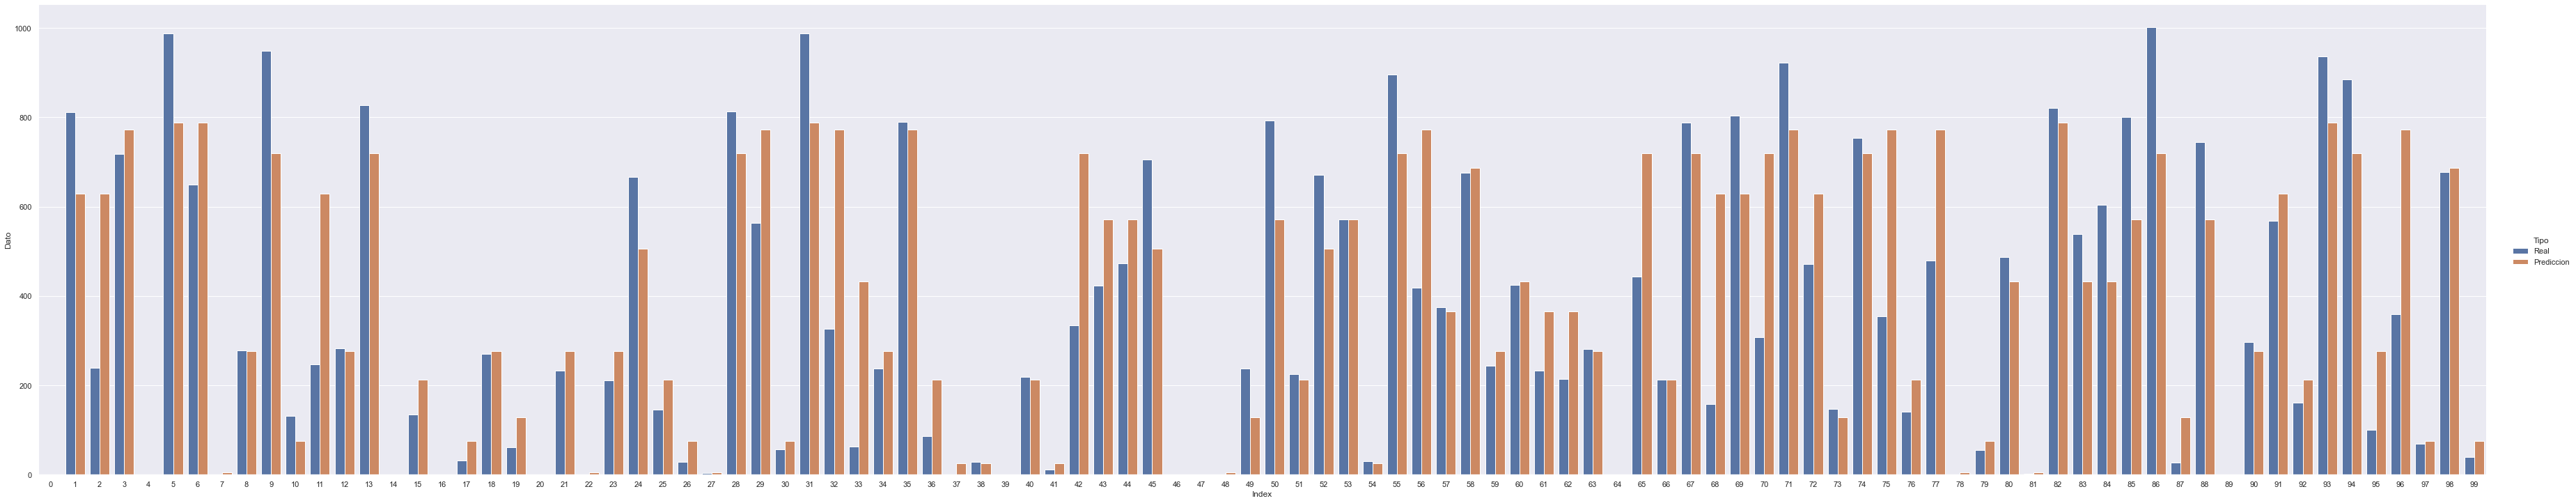

In [39]:
y_test_ = list(y_test.iloc[:,0])
graf_compara('Modelo medias horarias', y_test_[:100], pred_media[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

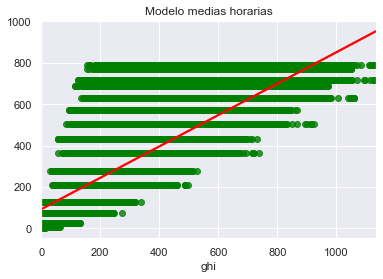

In [40]:
sns.regplot(x = y_test, y = pred_media,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo medias horarias');

Se obtienen las métricas de los resultados del modelo

In [41]:
metricas_media = metricas('Modelo de medias horarias', y_test, pred_media)

MODEL:  Modelo de medias horarias
MAE:  113.7072768497468
MSE:  157.63222465856856
RMSE:  157.63222465856856
R2 :  0.7591651862727734


In [42]:
%store metricas_media

Stored 'metricas_media' (tuple)


In [43]:
%store -r metricas_media

In [44]:
x_train = x_train_pca
x_test = x_test_pca

# Regresión lineal

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Se utiliza para estimar valores reales en función de variables continuas. Aquí, se establece la relación entre las variables independientes y dependientes mediante una recta. Esta línea de ajuste se conoce como línea de regresión y está representada por una ecuación lineal: ``Y = a * X + b``.

In [45]:
from sklearn.linear_model import LinearRegression

# Creo el modelo y lo entreno
regre = LinearRegression()
regre.fit(x_train, y_train)

# Obtengo la predicción
pred_reg_lineal_ = regre.predict(x_test)

In [46]:
pred_reg_lineal = []
[pred_reg_lineal.append(y[0]) for y in pred_reg_lineal_.tolist()]
pred_reg_lineal[:1000]

[120.92044205616759,
 880.0341008903499,
 350.15504223877326,
 867.8730976437757,
 51.100439209588956,
 929.35646730647,
 1065.2589901831566,
 19.631849321059065,
 131.23675132065006,
 967.0044268926741,
 5.316633910044743,
 387.95297269233953,
 305.7250809817217,
 713.0228222656252,
 112.63841753821669,
 200.18336250837308,
 49.5025852132988,
 16.61454691973836,
 198.1353226003092,
 115.10109794052744,
 144.5883977525843,
 260.9380367666778,
 36.939685084192774,
 149.30504067145807,
 547.9845625972666,
 204.17265868807073,
 20.58749953017184,
 79.81790068062043,
 736.6088683505857,
 842.6514933376183,
 140.23481404483366,
 951.541691651725,
 516.4484385434127,
 248.2610671671375,
 186.11626596830087,
 673.0897280905588,
 135.39407531178466,
 216.17865488847917,
 85.297273160548,
 42.49197131830317,
 260.55905702397,
 14.989471921466418,
 476.88715658126614,
 417.2497079265505,
 424.3944249538897,
 728.5688007627557,
 89.64927951389495,
 43.462009986426494,
 -9.565505946985127,
 184.65

Se comparan visualmente algunos valores ejemplo de predicción

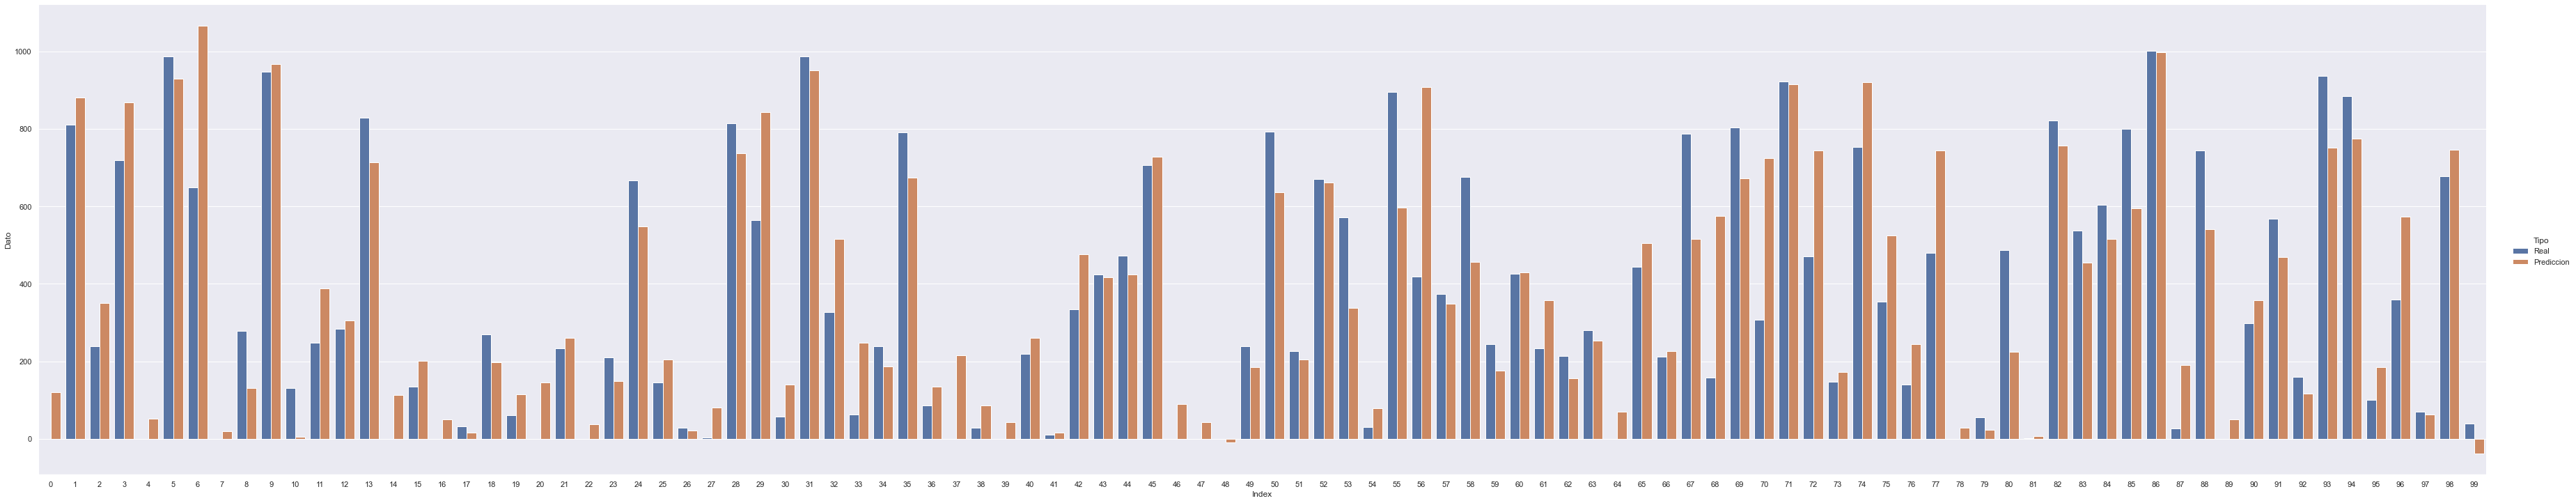

In [47]:
graf_compara('Modelo de regresión lineal', list(y_test[columnas_objetivo[0]])[:100], pred_reg_lineal[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

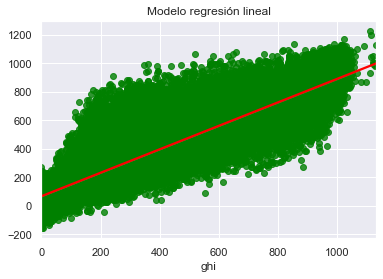

In [48]:
sns.regplot(x = y_test, y = pred_reg_lineal,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo regresión lineal');

Se obtienen las métricas de los resultados del modelo

In [49]:
metricas_regresion_lineal = metricas('Modelo de regresión lineal', y_test, pred_reg_lineal)

MODEL:  Modelo de regresión lineal
MAE:  99.69632559912249
MSE:  134.50080247520484
RMSE:  134.50080247520484
R2 :  0.8246608052548182


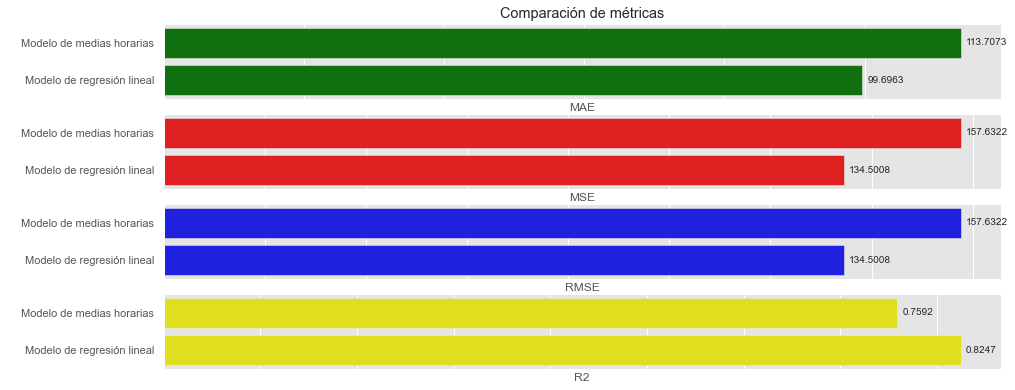

In [50]:
compracion_metricas([metricas_media,
                     metricas_regresion_lineal])

In [51]:
%store metricas_regresion_lineal

Stored 'metricas_regresion_lineal' (tuple)


In [52]:
%store -r metricas_regresion_lineal

# k-Nearest Neighbors

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Se puede utilizar tanto para problemas de clasificación como de regresión. kNN es un algoritmo simple que almacena todos los casos disponibles y clasifica los casos nuevos por mayoría de votos de sus k vecinos. El caso que se asigna a la clase es el más común entre sus K vecinos más cercanos medidos por una función de distancia.

[None]

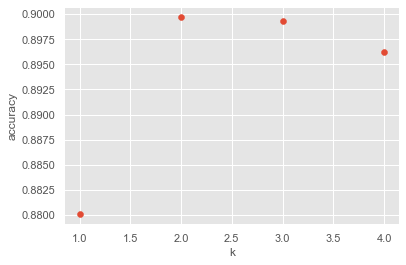

In [53]:
from sklearn.neighbors import KNeighborsRegressor

# Para un rango de número de puntos vecinos, se representa gráficamente la precisión del modelo
k_range = range(1, (len(x_train) if 5 > len(x_train) else 5))
scores = []
for k in k_range:
    knn = KNeighborsRegressor(n_neighbors = k, weights = 'uniform')
    knn.fit(x_train, y_train)
    scores.append(knn.score(x_test, y_test))
plt.figure();
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores);
k_ideal = []
[k_ideal.append(list(k_range)[i]) for i in range(0, len(scores)) if scores[i] == np.max(scores)]

In [54]:
from sklearn.neighbors import KNeighborsRegressor

# Se crea y entrena el modelo con el valor de k obtenido
knn = KNeighborsRegressor(n_neighbors = k_ideal[0], weights = 'uniform')

knn.fit(x_train, y_train)

# Se obtiene la predicción
pred_knn_ = knn.predict(x_test)

In [55]:
pred_knn = []
[pred_knn.append(y[0]) for y in pred_knn_.tolist()]
pred_knn[:10000]

[18.88665,
 776.4553,
 205.31535000000002,
 630.6589,
 0.0,
 991.8905,
 704.6076499999999,
 0.0,
 247.6376,
 890.8875,
 178.15545,
 314.22505,
 258.9357,
 845.2121500000001,
 0.9559,
 156.59425,
 0.0,
 47.1949,
 275.84535,
 31.115099999999998,
 0.0,
 207.6655,
 0.0,
 77.90055,
 650.6768999999999,
 42.013450000000006,
 12.9486,
 259.91325,
 875.294,
 376.59465,
 29.0652,
 979.7559,
 289.7645,
 72.33315,
 202.08955,
 742.6499,
 105.57275,
 44.40095,
 27.098750000000003,
 0.0,
 214.32485,
 31.5868,
 255.4896,
 579.0559000000001,
 399.6956,
 888.1303,
 0.0,
 83.51185,
 9.8343,
 343.57385,
 870.55425,
 313.16634999999997,
 930.93545,
 302.58555,
 42.36135,
 911.13105,
 370.1012,
 361.4144,
 525.889,
 241.54685,
 410.39239999999995,
 263.1334,
 172.73735,
 142.39985000000001,
 0.0,
 326.9688,
 63.74815,
 753.8575000000001,
 158.61464999999998,
 822.1385,
 277.0523,
 850.1148499999999,
 447.22270000000003,
 200.2323,
 719.71035,
 388.51595,
 146.2404,
 500.6117,
 0.0,
 97.60679999999999,
 551

Se comparan visualmente algunos valores ejemplo de predicción

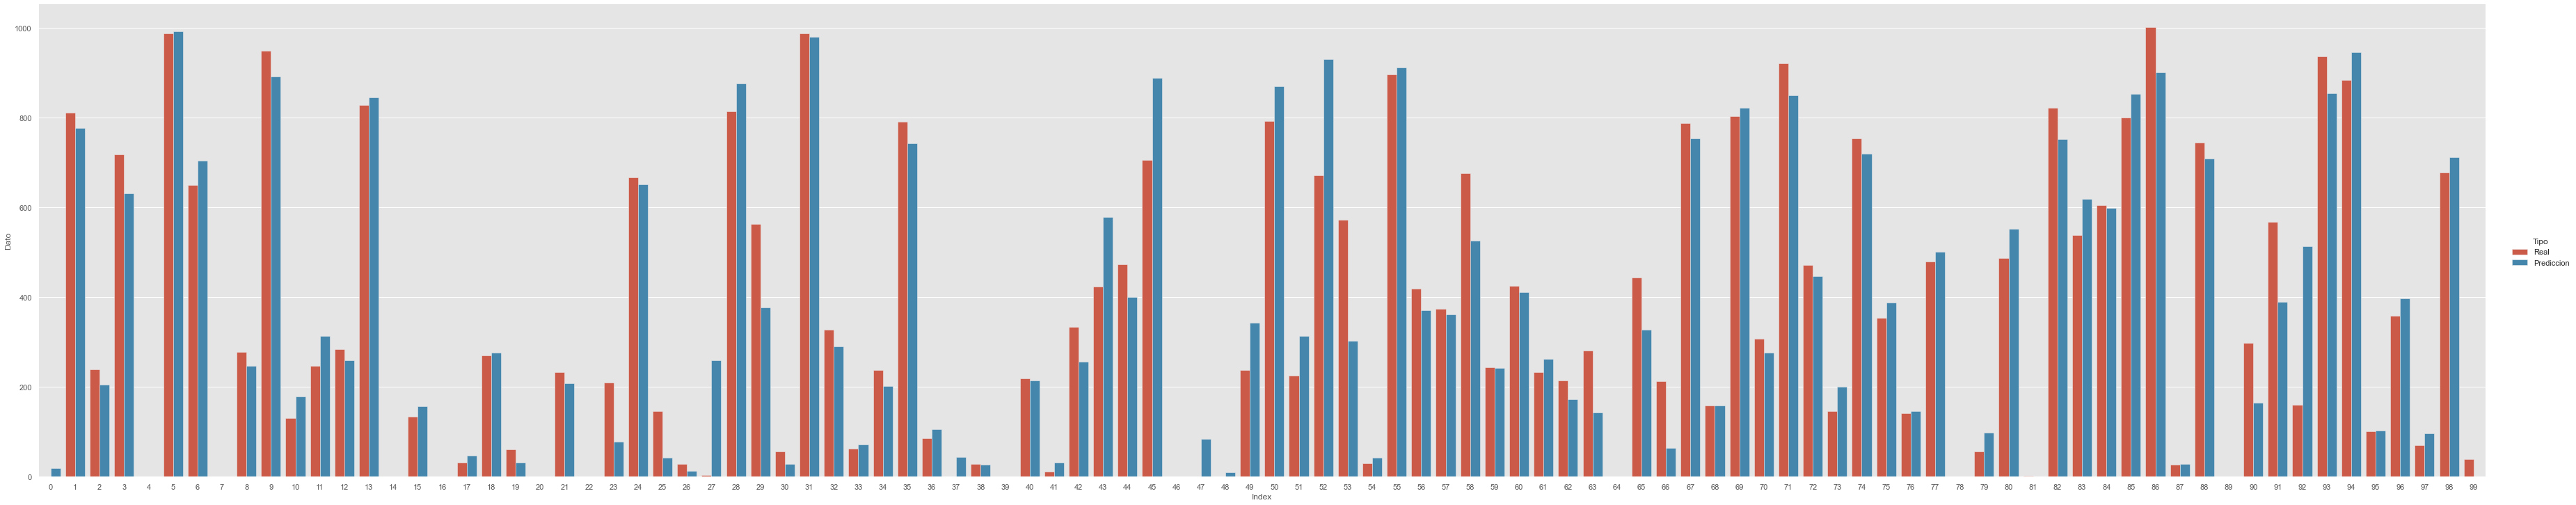

In [56]:
graf_compara('Modelo de knn', list(y_test[columnas_objetivo[0]])[:100], pred_knn[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

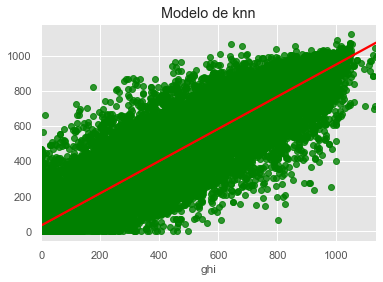

In [57]:
sns.regplot(x = y_test, y = pred_knn,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo de knn');

Se obtienen las métricas de los resultados del modelo

In [58]:
metricas_knn = metricas('Modelo de knn', y_test, pred_knn)

MODEL:  Modelo de knn
MAE:  64.23727145264145
MSE:  101.70708346310438
RMSE:  101.70708346310438
R2 :  0.8997390862846688


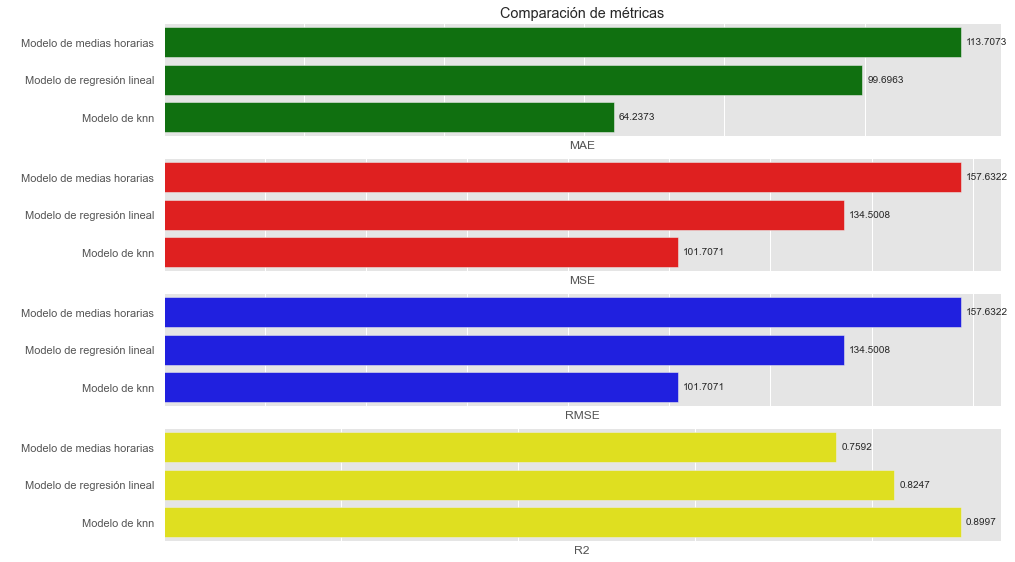

In [59]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn])

In [60]:
%store metricas_knn

Stored 'metricas_knn' (tuple)


In [61]:
%store -r metricas_knn

# Árbol de decisión

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Es un tipo de algoritmo de aprendizaje supervisado que funciona tanto para variables dependientes categóricas como continuas. Es un modelo predictivo que divide el espacio de los predictores agrupando observaciones con valores similares para la variable respuesta o dependiente.

In [62]:
from sklearn.tree import DecisionTreeRegressor

# Se crea y entrena el modelo
tree = DecisionTreeRegressor (max_depth = 20,
                              min_samples_leaf = 15)

tree.fit(x_train, y_train)

# Se obtiene la predicción
pred_tree_ = tree.predict(x_test)

In [63]:
pred_tree = []
[pred_tree.append(y) for y in pred_tree_.tolist()]
pred_tree[:1000]

[30.73784285714285,
 669.2322866666667,
 321.3750866666666,
 765.9090925925925,
 30.611839999999997,
 988.9342916666668,
 996.276153333333,
 0.0,
 208.36556000000004,
 986.2463076923077,
 133.97655333333333,
 214.14125769230765,
 162.4108272727273,
 623.756877777778,
 20.018636842105263,
 138.62435,
 0.1085375,
 4.9496866666666675,
 143.63962142857142,
 87.88757826086956,
 5.623661904761905,
 308.5648,
 2.5515875,
 95.31403333333334,
 536.1586066666666,
 75.331984,
 45.30373529411765,
 76.32636896551725,
 988.9342916666668,
 501.97674761904756,
 65.56240476190477,
 957.0689525423727,
 441.99510000000004,
 203.9755625,
 141.3558888888889,
 498.8316642857143,
 185.8800769230769,
 6.093372659176026,
 13.676837931034486,
 15.772149999999998,
 181.86921176470588,
 0.45577999999999996,
 251.07736875000006,
 436.6904380952381,
 394.34504375,
 811.281452631579,
 20.529149999999998,
 206.03426111111114,
 3.4350187500000002,
 47.67898333333334,
 808.9307666666667,
 69.92008750000001,
 841.330781

Se comparan visualmente algunos valores ejemplo de predicción

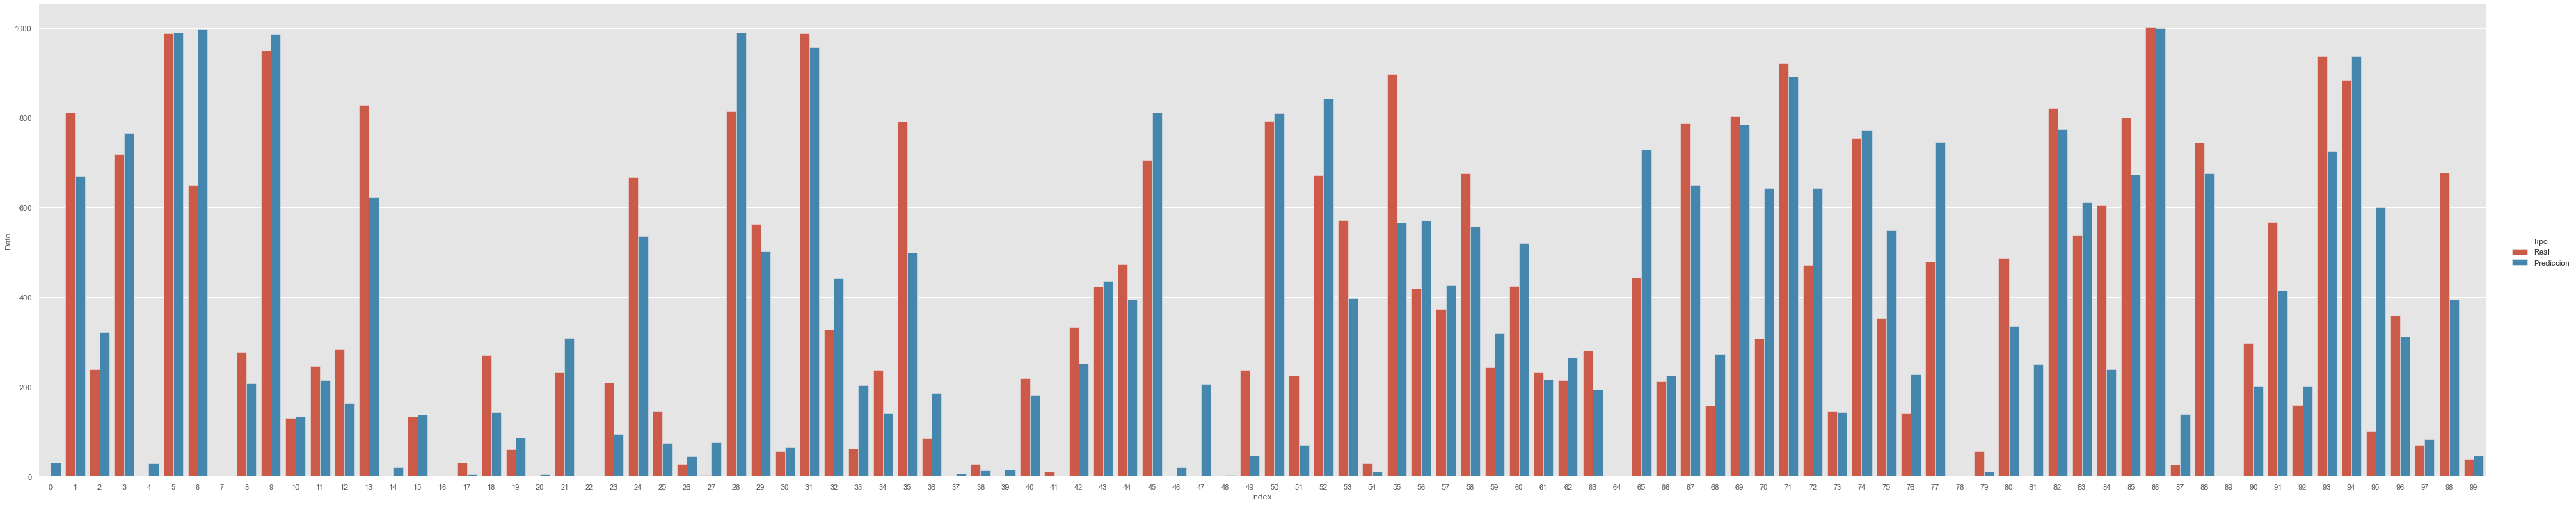

In [64]:
graf_compara('Modelo de árbol de decisión', list(y_test[columnas_objetivo[0]])[:100], pred_tree[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

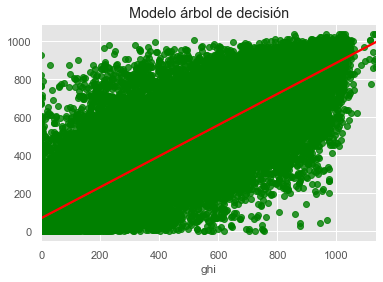

In [65]:
sns.regplot(x = y_test, y = pred_tree,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo árbol de decisión');

Se obtienen las métricas de los resultados del modelo

In [66]:
metricas_tree = metricas('Modelo de árbol de decisión', y_test, pred_tree)

MODEL:  Modelo de árbol de decisión
MAE:  109.79441624549816
MSE:  157.04286919843477
RMSE:  157.04286919843477
R2 :  0.7609626864363473


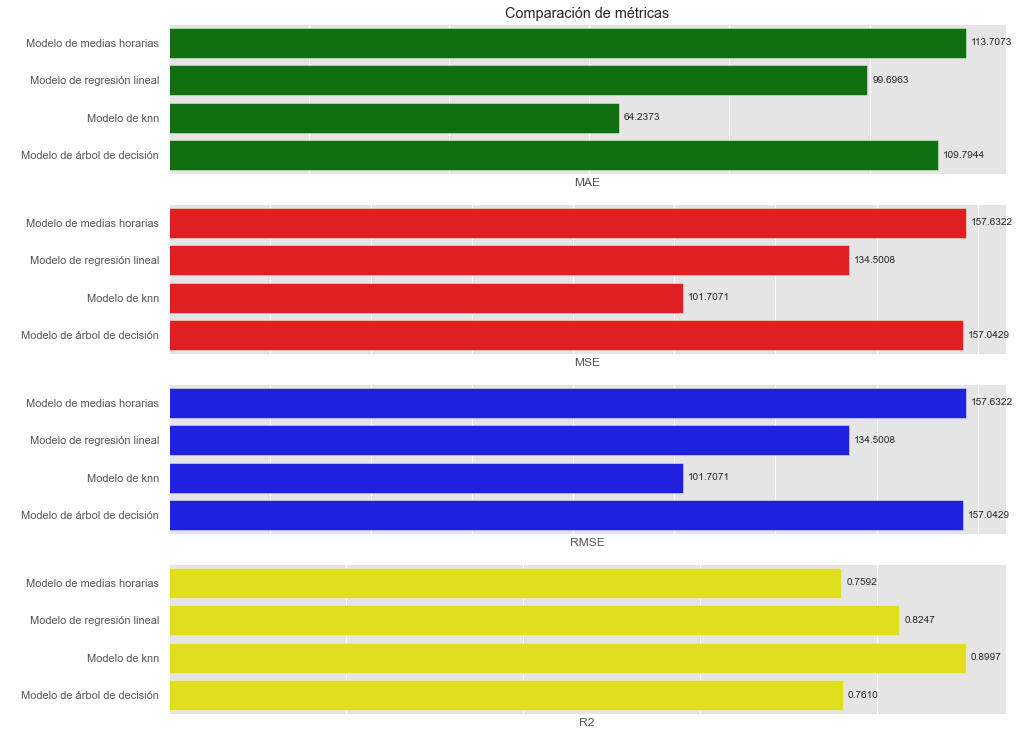

In [67]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree])

In [68]:
%store metricas_tree

Stored 'metricas_tree' (tuple)


In [69]:
%store -r metricas_tree

# Regresión polinomial 

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

**NO SE UTILIZA**: PROVOCA PROBLEMAS DE MEMORIA

Es un caso especial de la regresión lineal, extiende el modelo lineal al agregar predictores adicionales, obtenidos al elevar cada uno de los predictores originales a una potencia. Por ejemplo, una regresión cúbica utiliza tres variables, como predictores. Este enfoque proporciona una forma sencilla de proporcionar un ajuste no lineal a los datos.

In [70]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures 

# Se genera el estimador

class PolynomialRegression(BaseEstimator):
    def __init__(self, deg = None):
        self.deg = deg
            
    def fit(self, x, y, deg = None):
        self.model = LinearRegression()
        poli = PolynomialFeatures(degree = self.deg)
        x_ = poli.fit_transform(x)
        self.model.fit(x_, y)
    
    def predict(self, x):
        poli = PolynomialFeatures(degree = self.deg)
        x_ = poli.fit_transform(x)
        return self.model.predict(x_)

    def coef_(self):
        return pol_reg.coef_
    
    def best_params_(self):
        return pol_reg.best_params_

In [71]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression

# Se crea y entrena el modelo

#pol_reg = LinearRegression()
#poli = PolynomialFeatures(degree = 2)
#x_train_pol = poli.fit_transform(x_train)
#x_test_pol = poli.fit_transform(x_test)
#pol_reg.fit(x_train_pol, y_train)

#pred_pol_reg_ = pol_reg.predict(x_test_pol)

# Gradient boosting

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Gradient boosting o Potenciación del gradiente, es una técnica de aprendizaje automático utilizado para el análisis de la regresión y para problemas de clasificación, el cual produce un modelo predictivo en forma de un conjunto de modelos de predicción débiles, típicamente árboles de decisión. Construye el modelo de forma escalonada como lo hacen otros métodos de boosting, y los generaliza permitiendo la optimización arbitraria de una función de pérdida diferenciable.

En Gradient Boosting, el número de árboles es un hiperparámetro crítico en cuanto que, conforme se añaden árboles, se incrementa el riesgo de overfitting.

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

# Se crea y entrena el modelo
gbm = GradientBoostingRegressor(
            n_estimators = 10,
            loss         = 'ls',
            max_features = 'auto',
            random_state = 123
         )

gbm.fit(x_train, y_train.values.ravel())

# Se obtiene la predicción
pred_gbm_ = gbm.predict(x_test)

In [73]:
pred_gbm = []
[pred_gbm.append(y) for y in pred_gbm_.tolist()]
pred_gbm[:1000]

[274.69102278823397,
 593.1065740174323,
 378.167168979302,
 609.7537367194557,
 206.2318539877585,
 638.7529225014327,
 605.8053796814617,
 264.100062929366,
 247.64189533697922,
 631.1282724023695,
 231.09594666779213,
 414.6600878286264,
 392.9859271636455,
 522.2493613250094,
 262.63492475817196,
 313.2212124881981,
 182.74210359312886,
 278.34983533167735,
 229.16309362892608,
 232.4592621797855,
 224.74488743331366,
 328.20377962400244,
 235.92994500615933,
 271.9329042309379,
 488.8023019528553,
 284.94318264633137,
 303.96131570061107,
 257.31891972578524,
 638.7529225014327,
 519.0283500842105,
 242.170230959824,
 609.7537367194557,
 359.29793363794454,
 261.27350378206967,
 384.82776922519133,
 528.6065506848596,
 245.80351220504667,
 257.31891972578524,
 315.6878887436684,
 222.28320574566268,
 400.82851272563244,
 281.17525957203685,
 407.85604243876486,
 219.86198368705018,
 279.59780858227816,
 389.6397688381276,
 243.59487751561684,
 199.97181088046446,
 205.323616750341

Se comparan visualmente algunos valores ejemplo de predicción

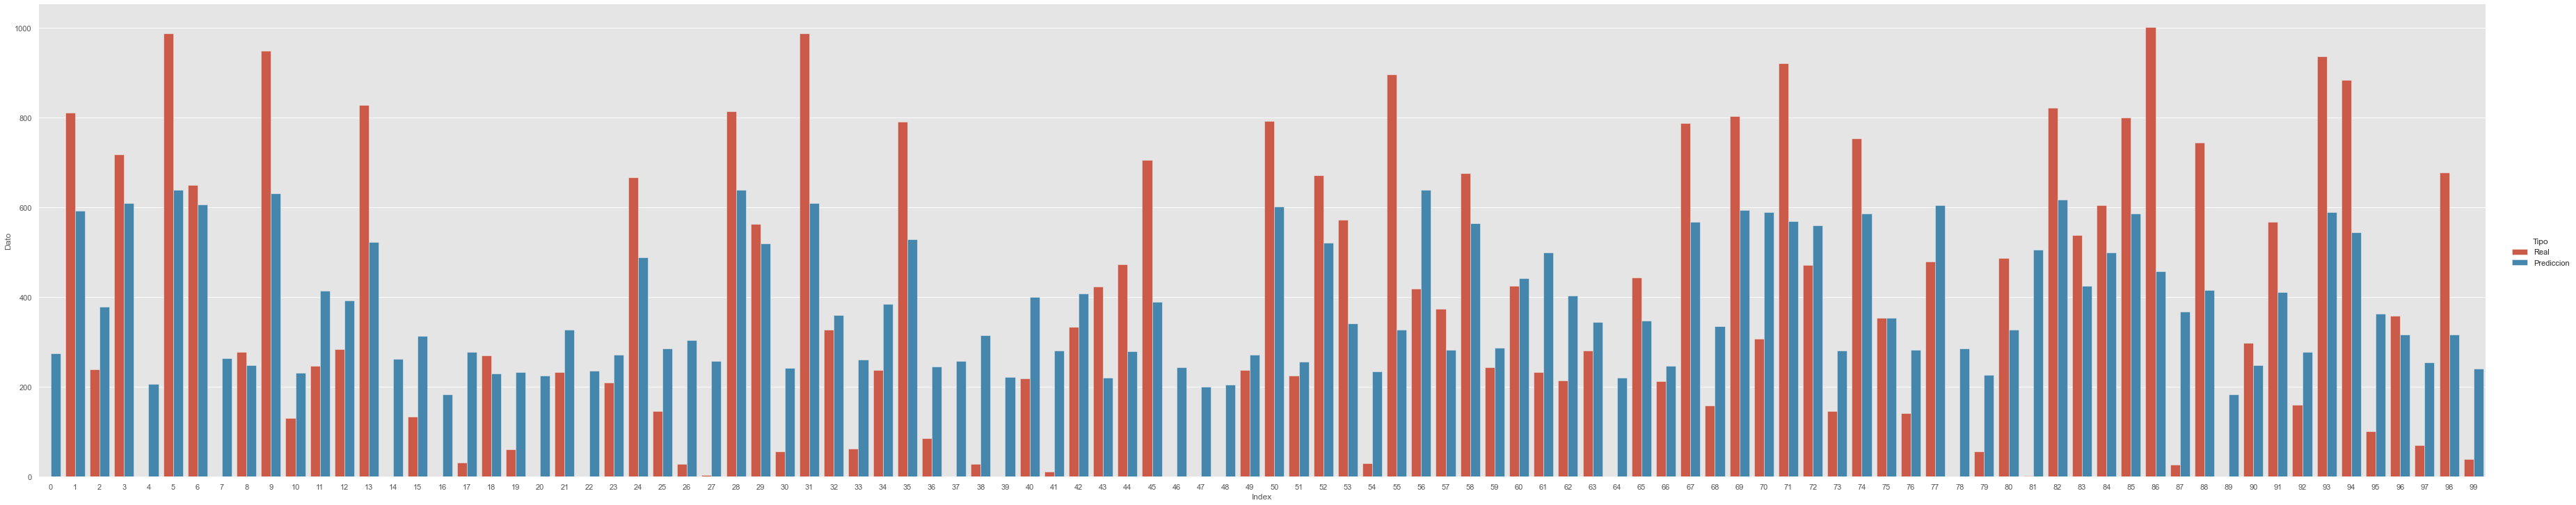

In [74]:
graf_compara('Modelo de Gradient boosting', list(y_test[columnas_objetivo[0]])[:100], pred_gbm[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

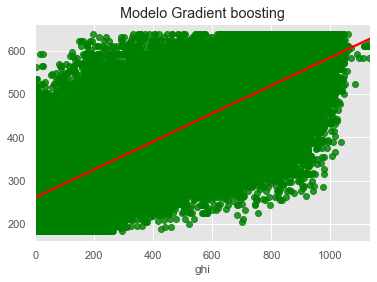

In [75]:
sns.regplot(x = y_test, y = pred_gbm,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo Gradient boosting');

Se obtienen las métricas de los resultados del modelo

In [76]:
metricas_gbm = metricas('Modelo de Gradient boosting', y_test, pred_gbm)

MODEL:  Modelo de Gradient boosting
MAE:  201.54200091646044
MSE:  232.44077346583924
RMSE:  232.44077346583924
R2 :  0.4763345991107423


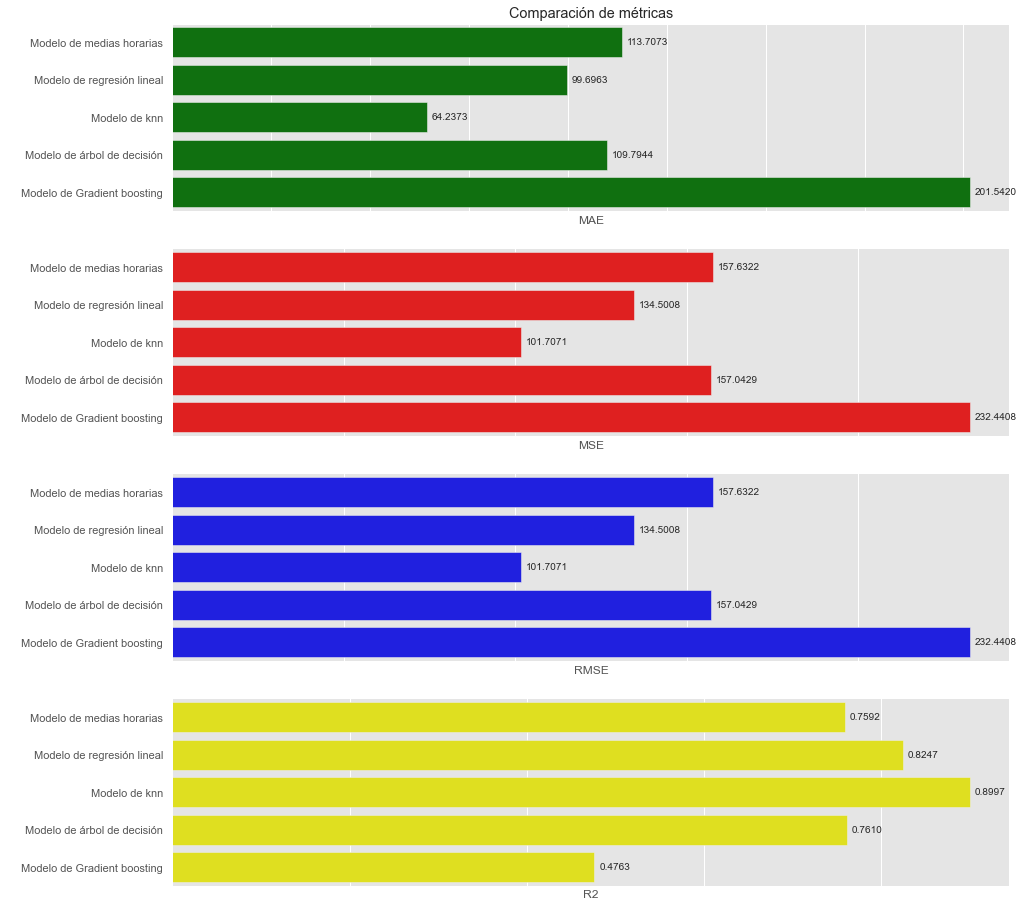

In [77]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm])

In [78]:
%store metricas_gbm

Stored 'metricas_gbm' (tuple)


In [79]:
%store -r metricas_gbm

# Random forest

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Random forest (o random forests) es una combinación de árboles predictores tal que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos. Es una modificación sustancial de bagging que construye una larga colección de árboles no correlacionados y luego los promedia.

In [80]:
from sklearn.ensemble import RandomForestRegressor

# Se crea y entrena el modelo
# n_jobs: -1 means using all processors
forest = RandomForestRegressor(max_depth = None,
                              min_samples_leaf = 1,
                              n_estimators = 100,
                              n_jobs = -1)
                            
forest.fit(x_train,y_train.values.ravel())

# Se obtiene la predicción
pred_forest_ = forest.predict(x_test)

In [81]:
pred_forest = []
[pred_forest.append(y) for y in pred_forest_.tolist()]
pred_forest[:1000]

[27.499725999999992,
 735.3866689999999,
 327.3189829999998,
 845.0122510000006,
 18.776289999999996,
 928.0425629999994,
 931.9289149999993,
 10.637669,
 152.14809900000003,
 961.1830190000001,
 129.293535,
 327.651836,
 307.606719,
 670.6531079999996,
 29.790835,
 182.45368599999998,
 5.9020379999999975,
 23.265338999999987,
 177.70334799999986,
 94.48130000000005,
 13.205024999999996,
 264.4593979999999,
 5.6604719999999995,
 199.45415400000002,
 656.7340859999998,
 167.55684800000006,
 77.87103900000001,
 166.13138500000005,
 756.0100249999999,
 554.897533,
 122.45367100000001,
 932.2961160000002,
 339.9214200000003,
 112.571178,
 370.16525700000005,
 658.9233590000002,
 215.81745799999993,
 46.78827200000001,
 105.71096100000001,
 11.161685,
 237.64545799999988,
 20.484098999999997,
 343.5486450000002,
 373.694339,
 384.2842060000001,
 739.7635150000002,
 157.01626800000003,
 28.426663000000012,
 19.20681399999999,
 194.66862400000005,
 700.0721659999997,
 163.720591,
 593.7477360

Se comparan visualmente algunos valores ejemplo de predicción

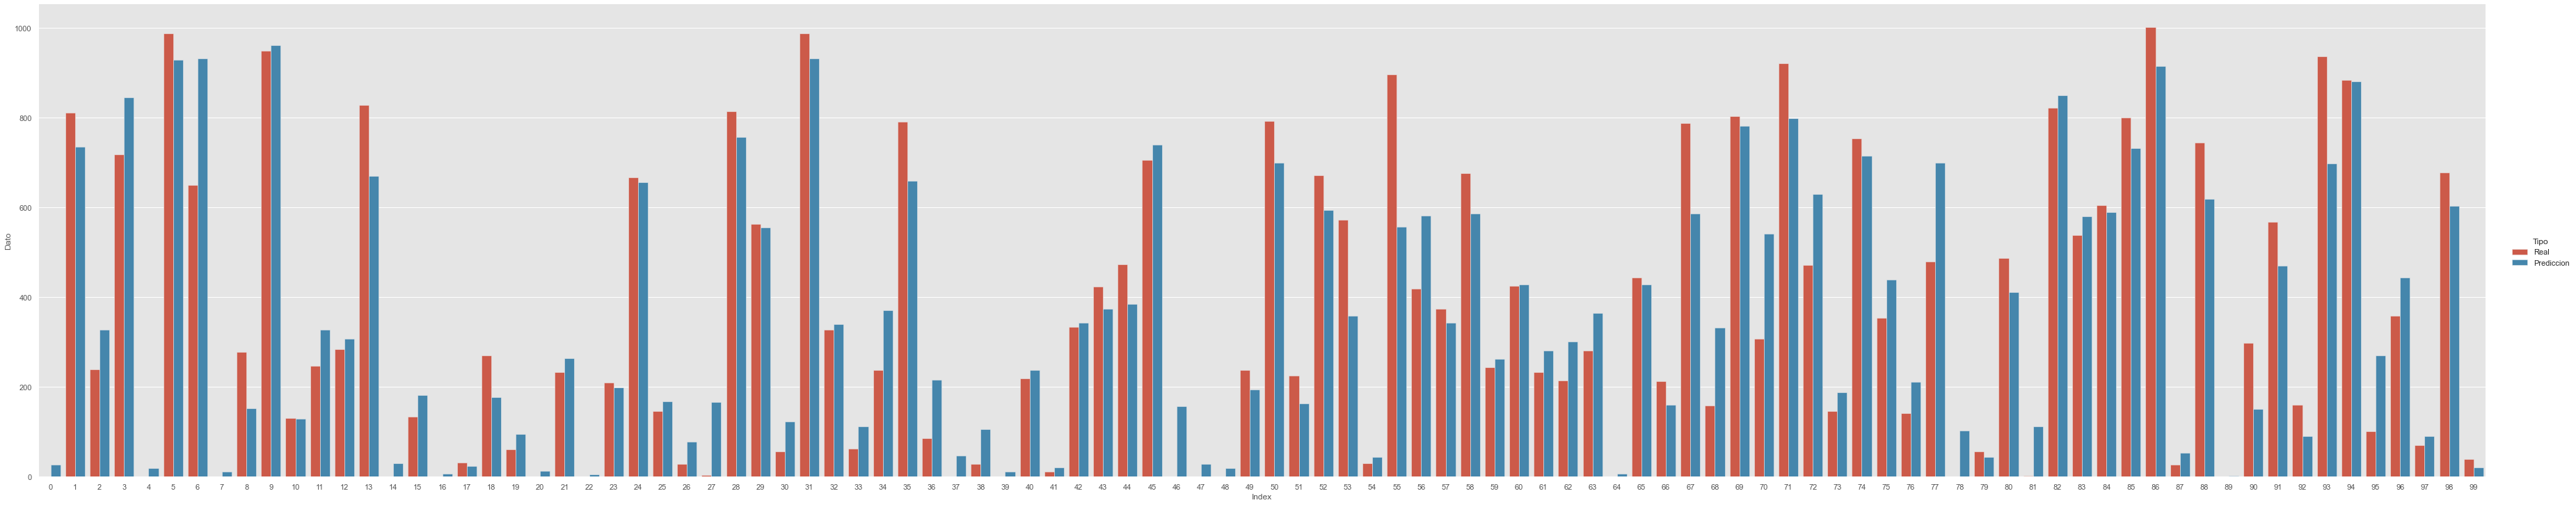

In [82]:
graf_compara('Modelo de random forest', list(y_test[columnas_objetivo[0]])[:100], pred_forest[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

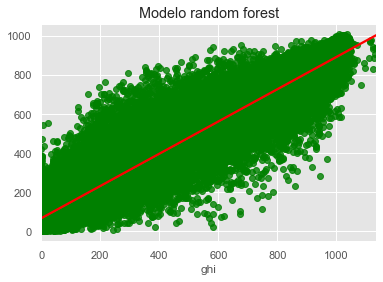

In [83]:
sns.regplot(x = y_test, y = pred_forest,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo random forest');

Se obtienen las métricas de los resultados del modelo

In [84]:
metricas_forest = metricas('Modelo de random forest', y_test, pred_forest)

MODEL:  Modelo de random forest
MAE:  78.52446201326593
MSE:  109.79880415454804
RMSE:  109.79880415454804
R2 :  0.8831511407250128


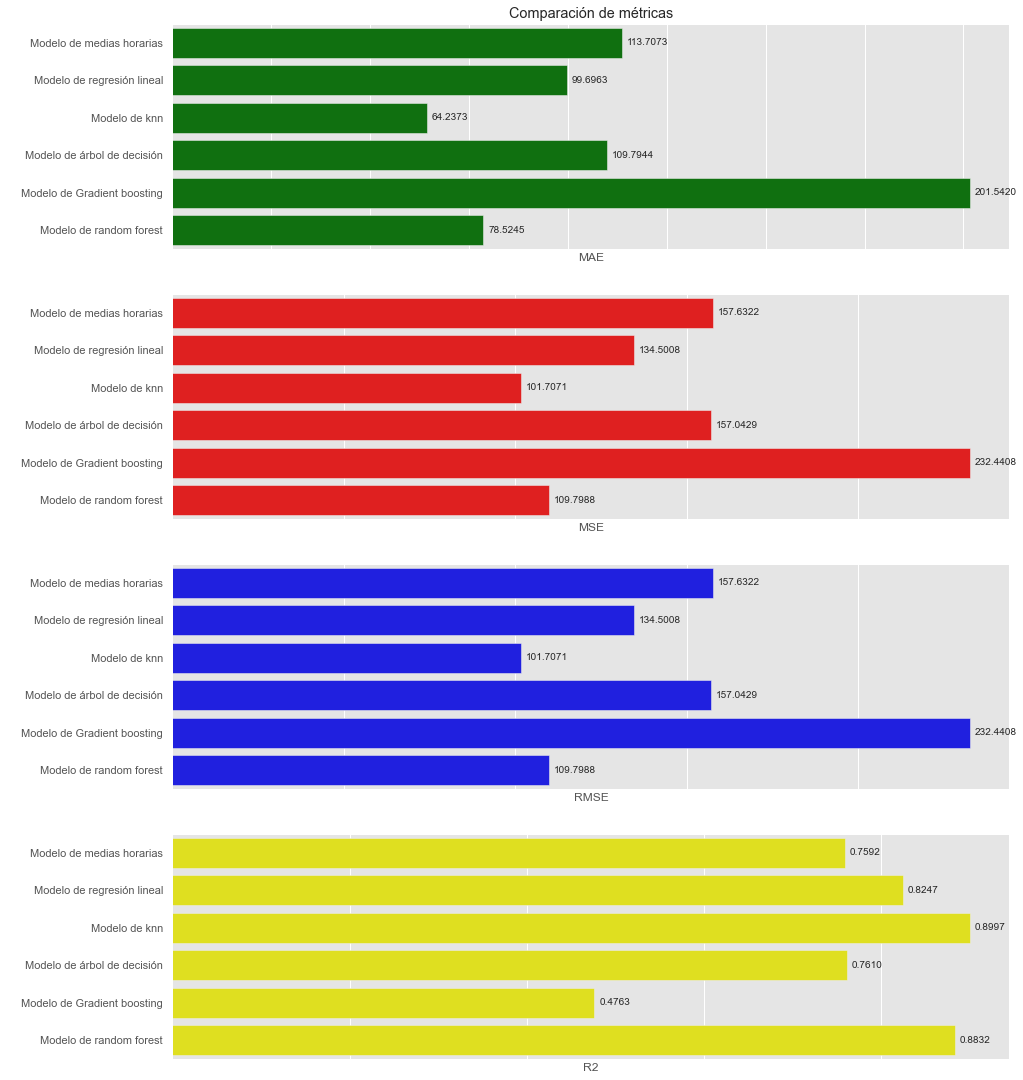

In [85]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest])

In [86]:
%store metricas_forest

Stored 'metricas_forest' (tuple)


In [87]:
%store -r metricas_forest

# Se comprueba que no haya sobreajuste

Una solución para saber si un modelo sufre de "overfitting" es un procedimiento llamado validación cruzada (CV). En el enfoque básico, llamado k-fold CV, el conjunto de entrenamiento se divide en k conjuntos más pequeños. Se sigue el siguiente procedimiento para cada uno de los k "pliegues":
- Un modelo se entrena usando ``k-1`` de los pliegues como datos de entrenamiento;

- El modelo resultante se valida en la parte restante de los datos (es decir, se utiliza como un conjunto de pruebas para calcular una medida de rendimiento como la precisión).

Se recomienda que el número de folds f se calcule como: ``m/f > n^2`` siendo m x n las dimensiones del conjunto de datos

In [88]:
x.shape

(156289, 75)

In [89]:
f = (x.shape[0]/(x.shape[1])**2)/5
f

5.556942222222222

In [90]:
scalar_sobredimension = StandardScaler()
pca_sobredimension = PCA(n_components = 62)
model = knn

pipeline = Pipeline([('transformer', scalar_sobredimension), ('pca', pca_sobredimension), ('estimator', model)])

scores = cross_val_score(pipeline, x, y.values.ravel(), cv = int(f), scoring = 'r2')
scores_numerico = []
[scores_numerico.append(float(i)) for i in list(scores)]
print(scores_numerico)
print("El valor medio de R² es {}, con desviación estándar de {}".format(np.mean(scores_numerico), np.std(scores_numerico)))

[0.4812385750300603, 0.36917312431522065, 0.6418371401450134, 0.6130442020107958, 0.5833042928306416]
El valor medio de R² es 0.5377194668663463, con desviación estándar de 0.10019006208374505


El mejor modelo entrenado hasta el momento es el de k-Nearest Neighbors, sin embargo, se puede comprobar que se encuentra sobreajustado

# GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

GridSearchCV es una clase disponible en scikit-learn que permite evaluar y seleccionar de forma sistemática los parámetros de un modelo. Indicándole un modelo y los parámetros a probar, puede evaluar el rendimiento del primero en función de los segundos mediante validación cruzada. Esta función ayuda a recorrer hiperparámetros predefinidos y ajustar su estimador (modelo) en su conjunto de entrenamiento. 

Por ello, se va a aplicar a los modelos previamente testeados, con r² como métrica

# Regresión lineal con GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [91]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# Se crea y entrena el modelo
regre_grid = GridSearchCV(LinearRegression(),
                       param_grid = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]},
                       cv = 2,
                       scoring = "r2")

regre_grid.fit(x_train,y_train)

# Se obtiene la predicción
pred_reg_grid_ = regre_grid.predict(x_test)

#Parámetros escogidos
regre_grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'normalize': True}

In [92]:
pred_reg_grid = []
[pred_reg_grid.append(y[0]) for y in pred_reg_grid_.tolist()]
pred_reg_grid[:1000]

[120.9204420561673,
 880.0341008903486,
 350.15504223877315,
 867.8730976437756,
 51.10043920958924,
 929.3564673064687,
 1065.2589901831564,
 19.631849321059292,
 131.23675132064974,
 967.0044268926739,
 5.316633910044175,
 387.9529726923399,
 305.72508098172125,
 713.0228222656252,
 112.63841753821708,
 200.18336250837177,
 49.50258521329897,
 16.61454691973779,
 198.13532260030843,
 115.1010979405279,
 144.58839775258429,
 260.93803676667835,
 36.93968508419192,
 149.30504067145893,
 547.9845625972664,
 204.17265868807047,
 20.5874995301715,
 79.81790068062048,
 736.6088683505857,
 842.6514933376181,
 140.23481404483306,
 951.5416916517253,
 516.4484385434129,
 248.2610671671376,
 186.1162659683,
 673.0897280905588,
 135.39407531178475,
 216.17865488847917,
 85.29727316054823,
 42.491971318303456,
 260.5590570239701,
 14.989471921467725,
 476.88715658126677,
 417.24970792655034,
 424.3944249538898,
 728.5688007627549,
 89.64927951389478,
 43.46200998642604,
 -9.56550594698598,
 184.

Se comparan visualmente algunos valores ejemplo de predicción

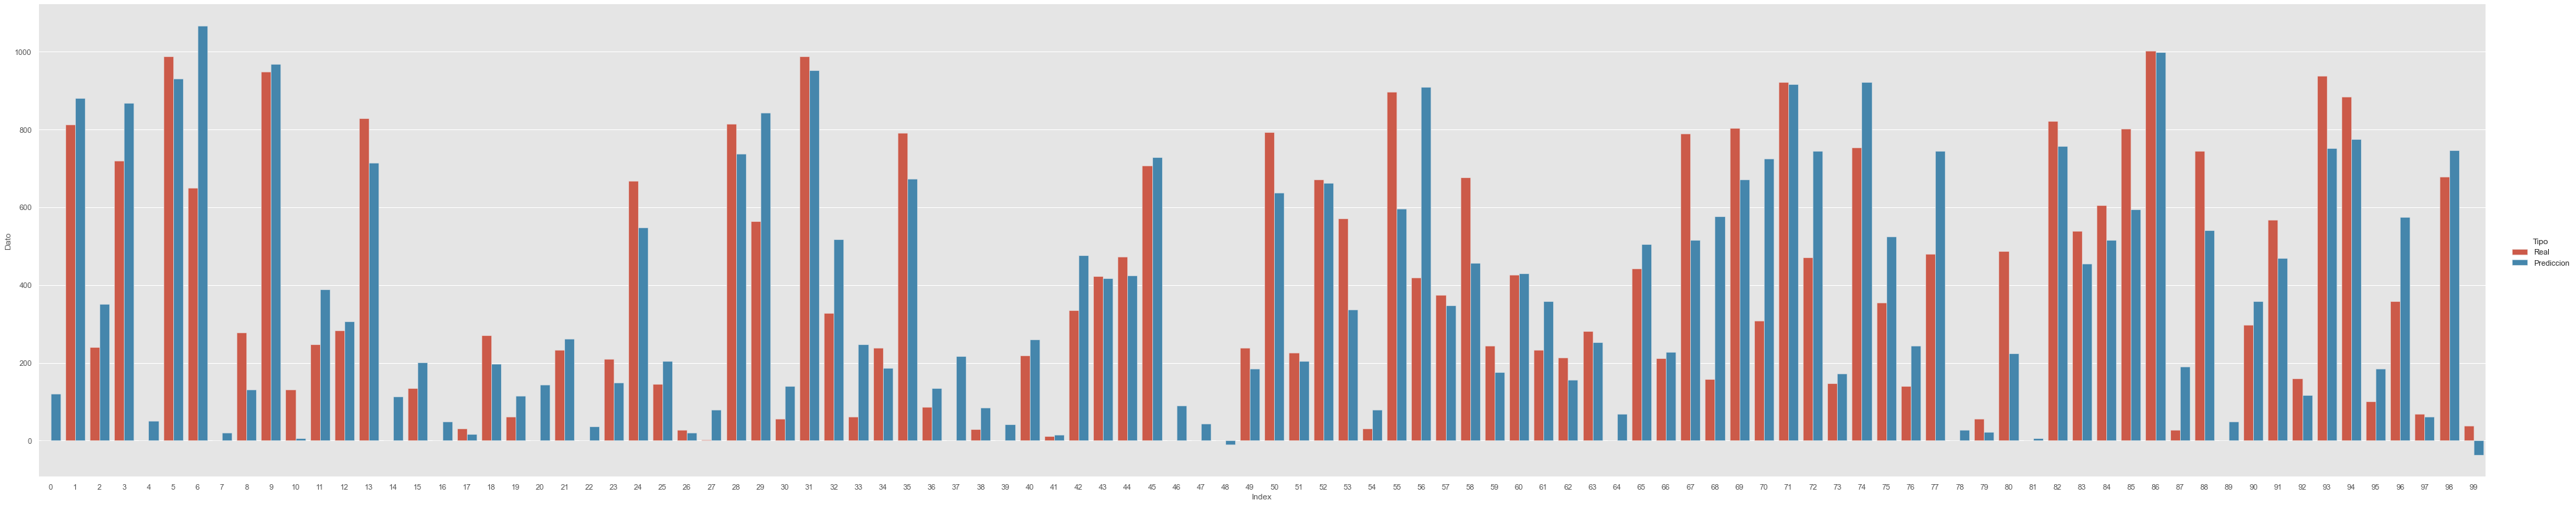

In [93]:
graf_compara('Modelo de regresión lineal con GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_reg_grid[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

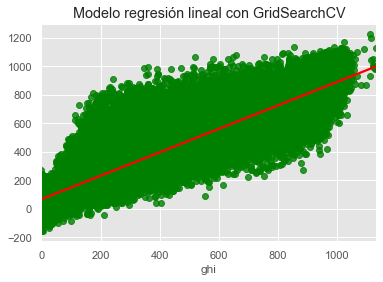

In [94]:
sns.regplot(x = y_test, y = pred_reg_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo regresión lineal con GridSearchCV');

Se obtienen las métricas de los resultados del modelo

In [95]:
metricas_reg_grid = metricas('Modelo de regresión lineal con GridSearchCV', y_test, pred_reg_grid)

MODEL:  Modelo de regresión lineal con GridSearchCV
MAE:  99.69632559912247
MSE:  134.50080247520484
RMSE:  134.50080247520484
R2 :  0.8246608052548182


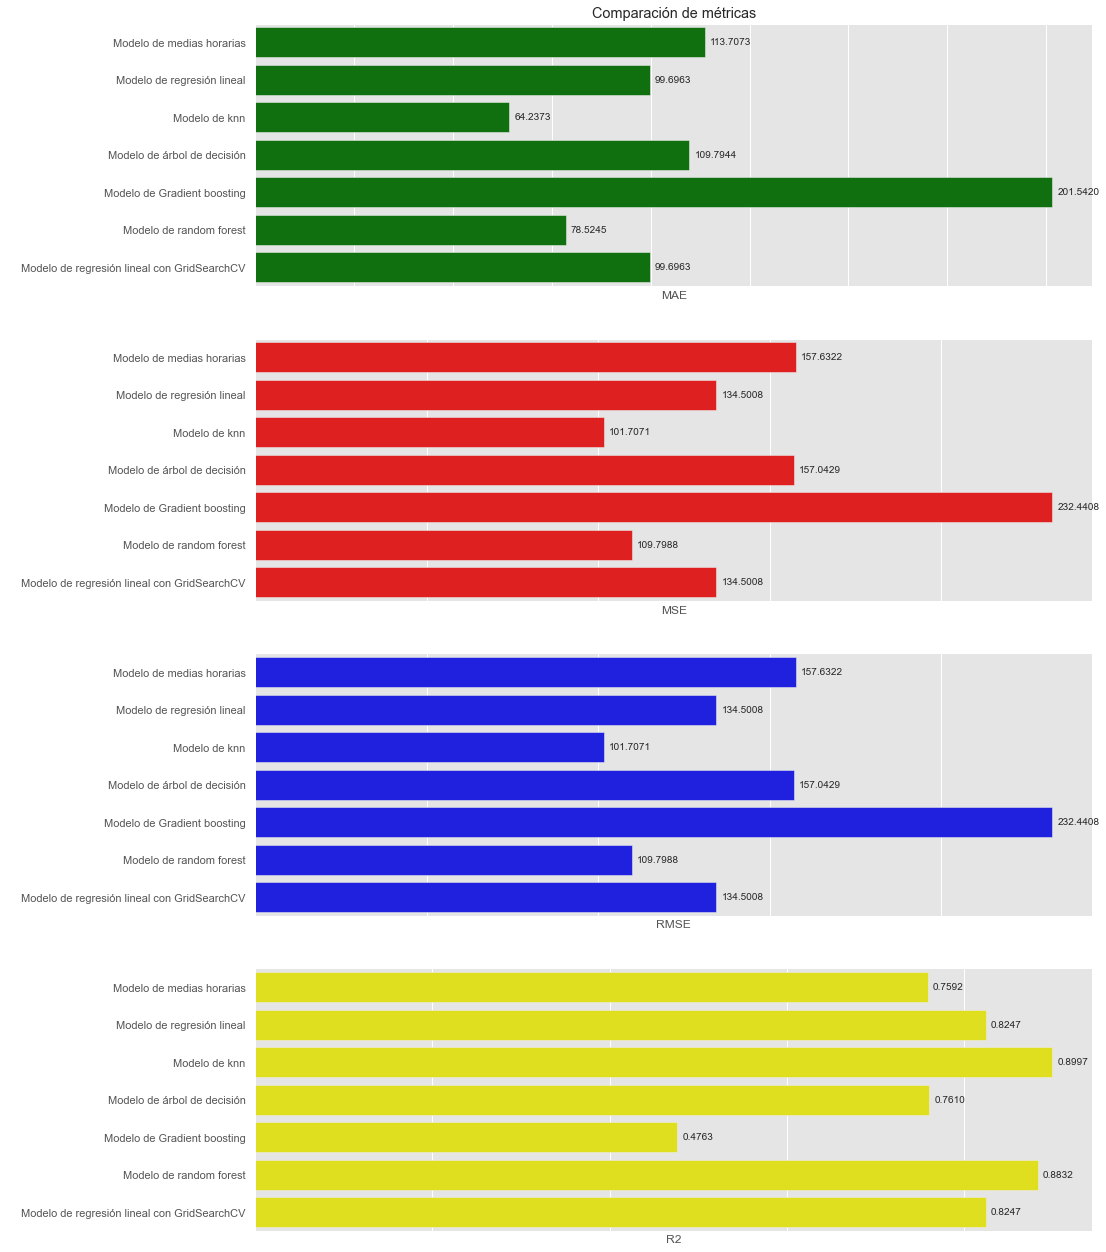

In [96]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid])

In [97]:
%store metricas_reg_grid

Stored 'metricas_reg_grid' (tuple)


In [98]:
%store -r metricas_reg_grid

# k-Nearest Neighbors con GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Se crea y entrena el modelo
knn_grid = GridSearchCV(KNeighborsRegressor(),
                       param_grid = {"n_neighbors":np.arange(1, 6),
                                     "leaf_size":np.arange(10, 30)},
                       cv = 2,
                       scoring = "r2")


knn_grid.fit(x_train, y_train)

# Se obtiene la predicción
pred_knn_grid_ = knn_grid.predict(x_test)

#Parámetros escogidos
knn_grid.best_params_

KeyboardInterrupt: 

In [ ]:
pred_knn_grid = []
[pred_knn_grid.append(y[0]) for y in pred_knn_grid_.tolist()]
pred_knn_grid[:1000]

Se comparan visualmente algunos valores ejemplo de predicción

In [ ]:
graf_compara('Modelo de knn con GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_knn_grid[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

In [ ]:
sns.regplot(x = y_test, y = pred_knn_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo knn con GridSearchCV');

Se obtienen las métricas de los resultados del modelo

In [ ]:
metricas_knn_grid = metricas('Modelo de knn con GridSearchCV', y_test, pred_knn_grid)

In [ ]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid])

In [ ]:
%store metricas_knn_grid

In [ ]:
%store -r metricas_knn_grid

# Árbol de decisión con GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [100]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Se crea y entrena el modelo
tree_grid = GridSearchCV(DecisionTreeRegressor(),
                       param_grid = {"max_depth":np.arange(25,35),
                                     "min_samples_leaf":np.arange(2,10)},
                       cv = 2,
                       scoring = "r2")

tree_grid.fit(x_train,y_train)

# Se obtiene la predicción
pred_tree_grid_ = tree_grid.predict(x_test)

# Parámetros escogidos
tree_grid.best_params_

{'max_depth': 29, 'min_samples_leaf': 9}

In [101]:
pred_tree_grid = []
[pred_tree_grid.append(y) for y in pred_tree_grid_.tolist()]
pred_tree_grid[:1000]

[0.0,
 670.2019785714284,
 331.35730714285717,
 847.3667727272727,
 9.292658333333334,
 909.4421928571429,
 974.5310111111111,
 0.0,
 47.63264,
 964.6688999999999,
 206.3971083333333,
 273.6553923076923,
 218.11964444444445,
 783.9140555555556,
 33.51727777777778,
 57.92568333333333,
 0.16073333333333334,
 5.725088888888888,
 219.12760999999995,
 57.73432,
 0.0,
 240.16945384615383,
 0.0,
 95.31403333333334,
 364.7789999999999,
 106.11580000000001,
 54.92388888888889,
 144.31909090909087,
 840.6917785714286,
 750.7063555555557,
 117.07036000000001,
 996.4674928571428,
 407.20091,
 104.36280000000001,
 133.09265555555555,
 768.3456166666666,
 151.20458461538462,
 45.7065,
 25.970466666666667,
 0.0,
 228.5748,
 0.6385799999999999,
 346.93033,
 296.9082,
 394.34504375000006,
 660.6677777777778,
 36.092299999999994,
 0.2806222222222223,
 0.004825,
 52.07130000000001,
 777.0224384615386,
 58.39705882352941,
 812.2522823529409,
 306.6914933333333,
 172.69263333333336,
 566.42256875,
 435.639

Se comparan visualmente algunos valores ejemplo de predicción

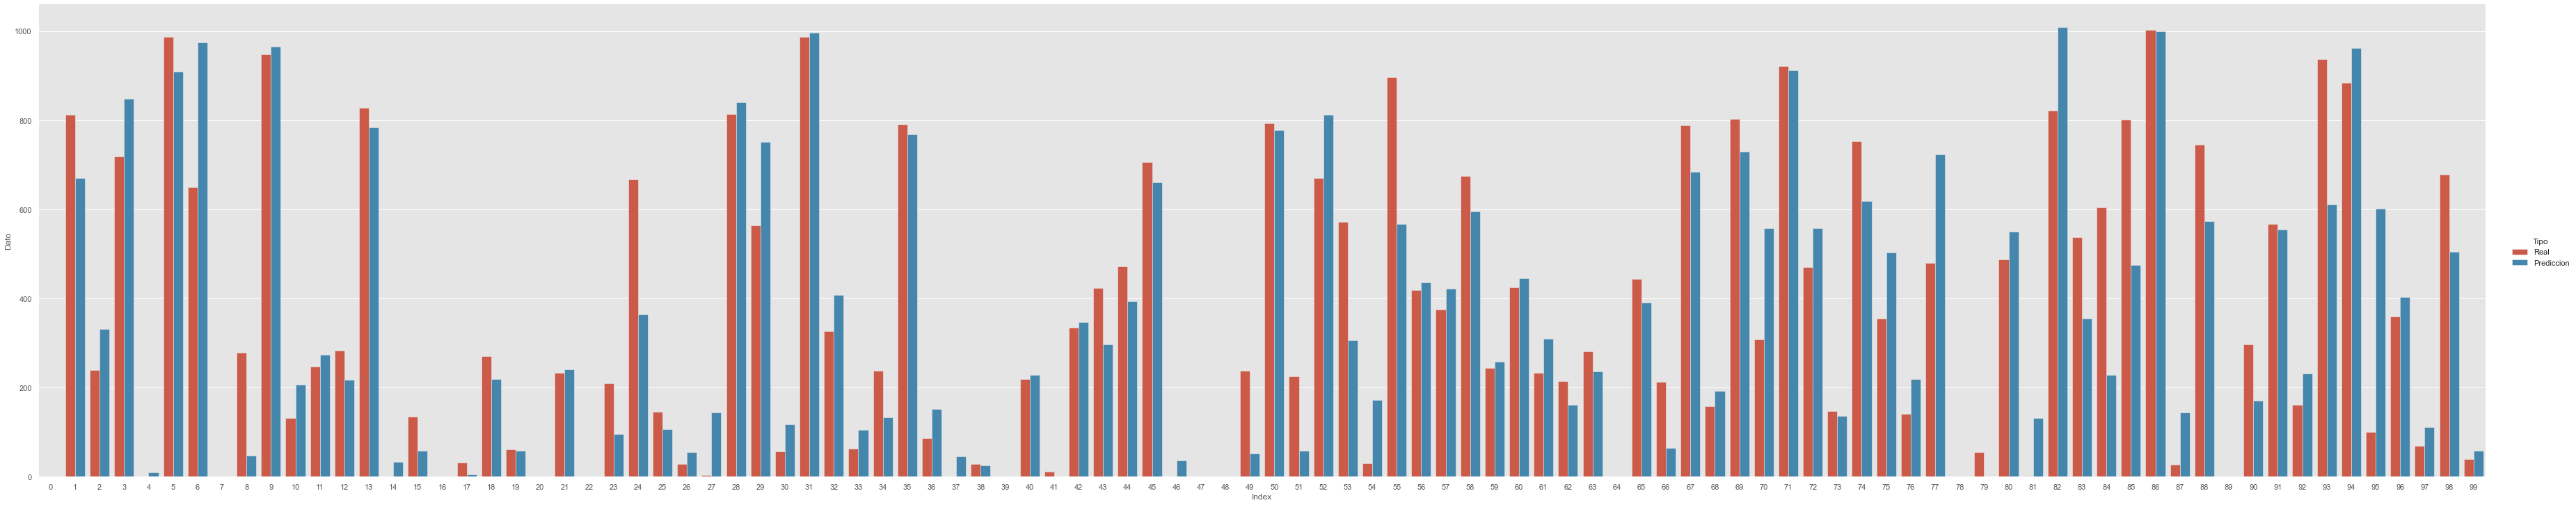

In [102]:
graf_compara('Modelo de árbol de decisión con GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_tree_grid[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

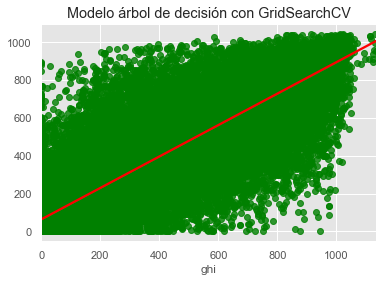

In [103]:
sns.regplot(x = y_test, y = pred_tree_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo árbol de decisión con GridSearchCV');

Se obtienen las métricas de los resultados del modelo

In [104]:
metricas_tree_grid = metricas('Modelo de árbol de decisión con GridSearchCV', y_test, pred_tree_grid)

MODEL:  Modelo de árbol de decisión con GridSearchCV
MAE:  108.33390590179276
MSE:  159.12279560421598
RMSE:  159.12279560421598
R2 :  0.7545889818642408


In [ ]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid])

In [ ]:
%store metricas_tree_grid

In [ ]:
%store -r metricas_tree_grid

# Gradient boosting con GridSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Se crea y entrena el modelo

# n_jobs: -1 means using all processors
gbm_grid =  GridSearchCV(GradientBoostingRegressor(),
                       param_grid = {'n_estimators':[100,500], 
                                'learning_rate': [0.1,0.05,0.02],
                                'max_depth':[4], 
                                'min_samples_leaf':[3], 
                                'max_features':[1.0] },
                       cv = 2,
                       scoring = "neg_mean_absolute_error")
                            
gbm_grid.fit(x_train,y_train.values.ravel())

# Se obtiene la predicción
pred_gbm_grid_ = gbm_grid.predict(x_test)

# Parámetros escogidos
gbm_grid.best_params_

In [ ]:
pred_gbm_grid = []
[pred_gbm_grid.append(y) for y in pred_gbm_grid_.tolist()]
pred_gbm_grid[:1000]

Se comparan visualmente algunos valores ejemplo de predicción

In [ ]:
graf_compara('Modelo de gradient boosting con GridSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_gbm_grid[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

In [ ]:
sns.regplot(x = y_test, y = pred_gbm_grid,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo gradient boosting con GridSearchCV');

Se obtienen las métricas de los resultados del modelo

In [ ]:
metricas_gbm_grid = metricas('Modelo de gradient boosting con GridSearchCV', y_test, pred_gbm_grid)

In [ ]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid,
                    metricas_gbm_grid])

In [ ]:
%store metricas_gbm_grid

In [ ]:
%store -r metricas_gbm_grid

# Random forest con Regressor RandomizedSearchCV

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

RandomizedSearchCV implementa un método de "ajuste" y "puntuación". Los parámetros del estimador utilizados para aplicar estos métodos se optimizan mediante una búsqueda con validación cruzada sobre la configuración de parámetros. A diferencia de GridSearchCV, no se prueban todos los valores de los parámetros, sino que se muestrea un número fijo de configuraciones de parámetros de las distribuciones especificadas. El número de ajustes de parámetros que se prueban viene dado por n_iter.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Se crea y entrena el modelo

forest_random = RandomizedSearchCV(RandomForestRegressor(),
                       param_distributions={"max_depth":np.arange(25,35),
                                  "min_samples_leaf":np.arange(2,10),
                                  "n_estimators": (10,50,100,500)},
                       cv = 2,
                       scoring = "r2",
                       n_iter = 5)
                            
forest_random.fit(x_train,y_train.values.ravel())

# Se obtiene la predicción
pred_forest_random_ = forest_random.predict(x_test)

# Parámetros escogidos
forest_random.best_params_

In [ ]:
pred_forest_random = []
[pred_forest_random.append(y) for y in pred_forest_random_.tolist()]
pred_forest_random[:1000]

Se comparan visualmente algunos valores ejemplo de predicción

In [ ]:
graf_compara('Modelo de random forest con RandomizedSearchCV', list(y_test[columnas_objetivo[0]])[:100], pred_forest_random[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

In [ ]:
sns.regplot(x = y_test, y = pred_forest_random,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo random forest con RandomizedSearchCV');

Se obtienen las métricas de los resultados del modelo

In [ ]:
metricas_forest_random = metricas('Modelo de random forest con RandomizedSearchCV', y_test, pred_forest_random)

In [ ]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid,
                    metricas_gbm_grid,
                    metricas_forest_random])

In [ ]:
%store metricas_forest_random

In [ ]:
%store -r metricas_forest_random

# Tensorflow

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

TensorFlow es el sistema de aprendizaje automático de segunda generación de Google Brain, liberado como software de código abierto en 9 de noviembre de 2015. TensorFlow es una plataforma de código abierto de extremo a extremo para el aprendizaje automático. Cuenta con un ecosistema integral y flexible de herramientas, bibliotecas y recursos de la comunidad que les permite a los investigadores innovar con el aprendizaje automático y, a los desarrolladores, compilar e implementar con facilidad aplicaciones con tecnología de aprendizaje automático.

In [ ]:
#! pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model

# Se crea y entrena el modelo

input_layer = Input(shape = (x_train_pca.shape[1],))
dense_layer_1 = Dense(100, activation = 'relu')(input_layer)
dense_layer_2 = Dense(50, activation = 'relu')(dense_layer_1)
dense_layer_3 = Dense(25, activation = 'relu')(dense_layer_2)
output = Dense(1)(dense_layer_3)

tensor = Model(inputs = input_layer, outputs = output)
tensor.compile(loss = "mean_squared_error" , optimizer = "adam", metrics = ["mean_squared_error"])

tensor.fit(x_train, y_train.values.ravel(), batch_size = 2, epochs = 100, verbose = 1, validation_split = 0.2)

# Se obtiene la predicción
pred_tensor_ = tensor.predict(x_test)

In [ ]:
pred_tensor = []
[pred_tensor.append(y[0]) for y in pred_tensor_.tolist()]
pred_tensor[:1000]

Se comparan visualmente algunos valores ejemplo de predicción

In [ ]:
graf_compara('Modelo de TensorFlow', list(y_test[columnas_objetivo[0]])[:100], pred_tensor[:100])

Se comparan visualmente los valores de predicción y la tendencia general de los valores objetivo

In [ ]:
sns.regplot(x = y_test, y = pred_tensor,  scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo tensor flow');

Se obtienen las métricas de los resultados del modelo

In [ ]:
metricas_pred_tensor = metricas('Modelo de tensor flow', y_test, pred_tensor)

In [ ]:
compracion_metricas([metricas_media,
                    metricas_regresion_lineal,
                    metricas_knn,
                    metricas_tree,
                    metricas_gbm,
                    metricas_forest,
                    metricas_reg_grid,
                    metricas_knn_grid,
                    metricas_tree_grid,
                    metricas_gbm_grid,
                    metricas_forest_random,
                    metricas_pred_tensor])

In [ ]:
%store metricas_pred_tensor

In [ ]:
%store -r metricas_pred_tensor

# Selección de modelo
<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Se muestra una comparativa de los resultados de los diferentes modelos

In [ ]:
fig, ax = plt.subplots(4,3, figsize = (15,22))
fig.suptitle('Valores predichos frente a reales', fontsize = 20, fontweight = 'bold')
fig.tight_layout()
fig.subplots_adjust(top = 0.95, hspace = 0.15)

sns.regplot(x = y_test, y = pred_media, ax = ax[0,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo medias horarias');
sns.regplot(x = y_test, y = pred_reg_lineal, ax = ax[0,1],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo regresión lineal');
sns.regplot(x = y_test, y = pred_knn, ax = ax[0,2],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo de knn');
sns.regplot(x = y_test, y = pred_tree, ax = ax[1,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo árbol de decisión');
sns.regplot(x = y_test, y = pred_gbm, ax = ax[1,1],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo Gradient boosting');
sns.regplot(x = y_test, y = pred_forest, ax = ax[1,2],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo random forest');
sns.regplot(x = y_test, y = pred_reg_grid, ax = ax[2,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo regresión lineal con GridSearchCV');
sns.regplot(x = y_test, y = pred_knn_grid,  ax = ax[2,1],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo knn con GridSearchCV');
sns.regplot(x = y_test, y = pred_tree_grid, ax = ax[2,2],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo árbol de decisión con GridSearchCV');
sns.regplot(x = y_test, y = pred_gbm_grid, ax = ax[3,0],
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo gradient boosting con GridSearchCV');
sns.regplot(x = y_test, y = pred_forest_random, ax = ax[3,1], 
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo random forest con RandomizedSearchCV');
sns.regplot(x = y_test, y = pred_tensor, ax = ax[3,2], 
            scatter_kws = {"color": "green"}, line_kws = {"color": "red"}).set_title('Modelo tensorflow');

for fila in ax:
    for columna in fila:
        columna.set_xlabel("")
        columna.set_ylabel("")

La media de valor de radiación solar en plano horizontal por hora (W/m²) es:

In [ ]:
# Se obtiene la media de la variable objetivo

df[columnas_objetivo].mean()

El mae del método de k-Nearest Neighbors con GridSearchCV sobre el valor medio es:

In [ ]:
metricas_knn[1]/df[columnas_objetivo].mean()[0]*100

El modelo seleccionado es el de k-Nearest Neighbors, que cuenta con mayor r² (90 %) que el resto de modelos y menor error medio (16 % sobre el valor medio).

# Se comprueba que no haya sobreajuste

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

Pruebo el modelo con otros grupos de datos aleatorios, para comprobar si los resultados son similares

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA

resultados = []

for i in range(1,5):
    
    # Se obtienen los datos
    df_fin = df_datos.sample(frac = 0.6, random_state = i)
    
    # Se dividen los datos en columnas objetivo y entrada y se dividen en train y test
    x_fin = df_fin[columnas_utiles]
    y_fin = df_fin[columnas_objetivo]
    x_train_fin, x_test_fin, y_train_fin, y_test_fin = dividir_train_test(x_fin,y_fin, 0.8)
    
    # Estandarización
    scaler = StandardScaler()
    columnas = x_train_fin.columns
    x_train_fin_normal = scaler.fit_transform(x_train_fin[columnas])
    x_train_fin_normal = pd.DataFrame(x_train_fin_normal, columns = columnas)
    
    columnas = x_test_fin.columns
    x_test_fin_normal = scaler.transform(x_test_fin[columnas])
    x_test_fin_normal = pd.DataFrame(x_test_fin_normal, columns = columnas)
    
    # PCA
    pca = PCA(n_components = 62)
    principalComponents = pca.fit_transform(x_train_fin_normal)
    x_train_fin_pca = pd.DataFrame(data = principalComponents)
    
    principalComponents = pca.transform(x_test_fin_normal)
    x_test_fin_pca = pd.DataFrame(data = principalComponents)
    
    # Se crea y entrena el modelo
    knn_fin = KNeighborsRegressor(n_neighbors = 4, leaf_size = 10, weights = 'uniform')

    knn_fin.fit(x_train_fin,y_train_fin.values.ravel())
    
    # Se obtiene la predicción
    pred_knn_fin_ = knn_fin.predict(x_test_fin)
    pred_knn_fin = []
    [pred_knn_fin.append(y) for y in pred_knn_fin_.tolist()]
    
    # Se obtienen las métricas del modelo
    metricas_final = metricas('Modelo de knn', y_test_fin, pred_knn_fin)
    
    
    # Se guardan los resultados
    resultados.append(metricas_final[4])

print("El valor medio de R² es {}, con desviación estándar de {}".format(np.mean(resultados), np.std(resultados)))

Se concluye que el modelo es válido.

# Se guarda el modelo

<div style = "float:right"><a style="text-decoration:none" href = "#Modelo-de-predicción:-Radiación-solar">

In [395]:
# Se guarda el modelo
modelo = "modelo_2_rad.pkl"

with open(directorio + 'data/Modelo_2/' + modelo, 'wb') as file:
        pk.dump(knn, file)    